In [2]:
import numpy as np
import pandas as pd


from datetime import datetime      # To access datetime
from pandas import Series          # To work on series
                
import warnings                    # To ignore the warnings
warnings.filterwarnings("ignore")  #
from openpyxl import load_workbook #to load excel file into program
import glob                        # helps in dealing with computer paths
import os                          #to deal with computer operating system
import statsmodels.api as sm

%matplotlib inline

#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
#from matplotlib import plt
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode()
from plotly import tools
import plotly.tools as tls
sns.set_style('whitegrid')
%matplotlib inline 

## Reading the Dataset

In [592]:
df = pd.read_csv('Monthly_data_cmo.csv')

In [608]:
MSP_df = pd.read_csv('CMO_MSP_Mandi_1.csv')

In [609]:
df.head(5)

APMC      Commodity  Year  Month  arrivals_in_qtl  min_price  \
0  Ahmednagar          Bajri  2015  April               79       1406   
1  Ahmednagar          Bajri  2016  April              106       1788   
2  Ahmednagar  Wheat(Husked)  2015  April             1253       1572   
3  Ahmednagar  Wheat(Husked)  2016  April              387       1750   
4  Ahmednagar  Sorgum(Jawar)  2015  April             3825       1600   

   max_price  modal_price     date district_name   state_name  
0       1538         1463  2015-04    Ahmadnagar  Maharashtra  
1       1925         1875  2016-04    Ahmadnagar  Maharashtra  
2       1890         1731  2015-04    Ahmadnagar  Maharashtra  
3       2220         1999  2016-04    Ahmadnagar  Maharashtra  
4       2200         1900  2015-04    Ahmadnagar  Maharashtra

In [610]:
MSP_df.head()

commodity  year          Type  msprice  msp_filter
0   PADDY-UNHUSKED  2012  Kharif Crops   1250.0           1
1  RICE(PADDY-HUS)  2012  Kharif Crops   1280.0           1
2     Jowar_Hybrid  2012  Kharif Crops   1500.0           1
3    SORGUM(JAWAR)  2012  Kharif Crops   1520.0           1
4            BAJRI  2012  Kharif Crops   1175.0           1

In [611]:
MSP_df.dtypes

commodity      object
year            int64
Type           object
msprice       float64
msp_filter      int64
dtype: object

In [612]:
#MSP_df["msprice"]=pd.to_numeric(MSP_df["msprice"])

## Cleaning the Dataset

First we make all the values in the dataset Upper Case to remove any case related ambiguity

In [613]:
print(len(df['Commodity'].unique()))

352


In [614]:
df = df.apply(lambda x: x.astype(str).str.upper())
MSP_df = MSP_df.apply(lambda x: x.astype(str).str.upper())

Removing Any Punctuation and White Saces in the Commodity and APMC

In [615]:
df2=df
df["Commodity"] = df["Commodity"].str.replace('[^\w\s]','')
df['Commodity'] = df['Commodity'].str.strip()
df["APMC"] = df["APMC"].str.replace('[^\w\s]','')
df['APMC'] = df['APMC'].str.strip()

Now we can clearley see the no unique values for both Commodity and APMC has been reduced
thus eleminating duplicates and ambigous values

In [616]:
print(len(df['Commodity'].unique()))

202


Simalarly removing the whitespaces and punctuation in the MSP dataset

In [617]:
MSP_df['commodity'] = MSP_df['commodity'].str.strip()
MSP_df['commodity'] = MSP_df['commodity'].str.replace('[^\w\s]','')

In [618]:
print(len(MSP_df["commodity"].unique()))

31


Now we can see the number of commodities in the MSP dataset is much less as compared to the 
Monthly data thus we will be focusing only on the commodties which are present in the MSP dataset

Thus finding the common commodties in both the dataset

In [619]:
common_commodities = list(set(MSP_df.commodity) & set(df2["Commodity"]))
print('The number of common commodities are')
print(len(common_commodities))

common_commodities.sort()
common_commodities

The number of common commodities are
19


['BAJRI',
 'COCONUT',
 'COTTON',
 'GRNUT KERNELS',
 'MAIZE',
 'MUSTARD',
 'NIGERSEED',
 'PADDYUNHUSKED',
 'PIGEON PEA TUR',
 'RICEPADDYHUS',
 'SAFFLOWER',
 'SESAMUM',
 'SORGUMJAWAR',
 'SPILT GERRN GRAM',
 'SPLIT BLACK GRAM',
 'SUGARCANE',
 'SUNFLOWER',
 'WHEATHUSKED',
 'WHEATUNHUSKED']

*So now we will be focusing on these 19 common commodities*

In [620]:
df2=df2.loc[df2["Commodity"] .isin(common_commodities)]

In [621]:
#Removing any NULL values if present
monthly_df = df2.dropna()

Thus now monthly_df is the dataset on which we will be further working which has only 
the 19 Commodities n whcih we wish to work

In [622]:
monthly_df.head()

APMC    Commodity  Year  Month arrivals_in_qtl min_price max_price  \
0  AHMEDNAGAR        BAJRI  2015  APRIL              79      1406      1538   
1  AHMEDNAGAR        BAJRI  2016  APRIL             106      1788      1925   
2  AHMEDNAGAR  WHEATHUSKED  2015  APRIL            1253      1572      1890   
3  AHMEDNAGAR  WHEATHUSKED  2016  APRIL             387      1750      2220   
4  AHMEDNAGAR  SORGUMJAWAR  2015  APRIL            3825      1600      2200   

  modal_price     date district_name   state_name  
0        1463  2015-04    AHMADNAGAR  MAHARASHTRA  
1        1875  2016-04    AHMADNAGAR  MAHARASHTRA  
2        1731  2015-04    AHMADNAGAR  MAHARASHTRA  
3        1999  2016-04    AHMADNAGAR  MAHARASHTRA  
4        1900  2015-04    AHMADNAGAR  MAHARASHTRA

In [623]:
monthly_df.dtypes

APMC               object
Commodity          object
Year               object
Month              object
arrivals_in_qtl    object
min_price          object
max_price          object
modal_price        object
date               object
district_name      object
state_name         object
dtype: object

In [624]:
#the prices are also string type thus
#Converting the prices into numeric type for working on them
monthly_df["modal_price"]=pd.to_numeric(monthly_df["modal_price"])
monthly_df["max_price"]=pd.to_numeric(monthly_df["max_price"])
monthly_df["min_price"]=pd.to_numeric(monthly_df["min_price"])


## Outlier Detection and Removal

Now for detecting the outlier we first plot the graphs for each commodity seperately as the prices for all the commodities vary

In [625]:
from pylab import rcParams


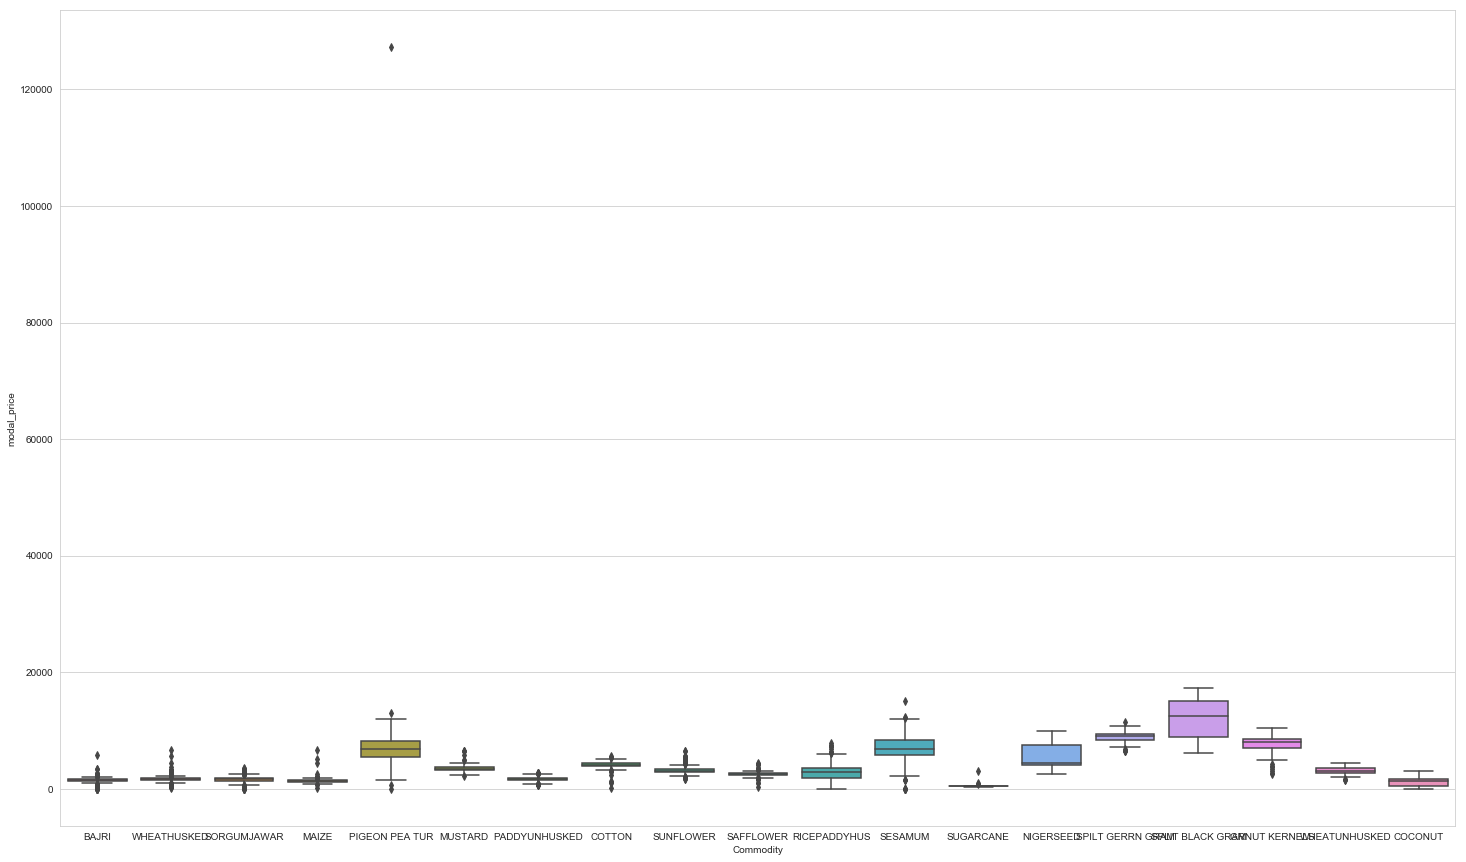

In [626]:
rcParams['figure.figsize'] = 25, 15
sns.boxplot(x=monthly_df['Commodity'] , y=monthly_df['modal_price']) 
plt.savefig('Box_plot.jpg')

.


*For better Visiualization of the outliers plotting each commodity Seperately as the prices of each commodity varies
So we iterate over out common_commodities list to plot each of the commodities scatter plot and an box plot for a better
visulzation of the outlier in the modal prices of individual commodity*




.



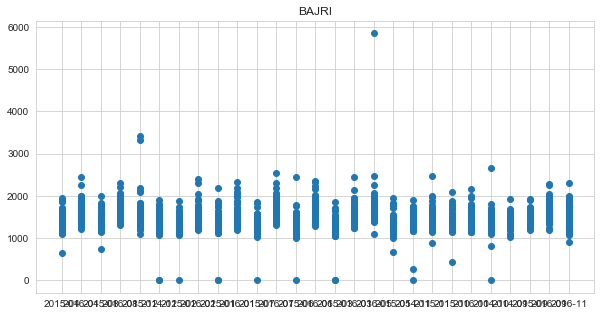

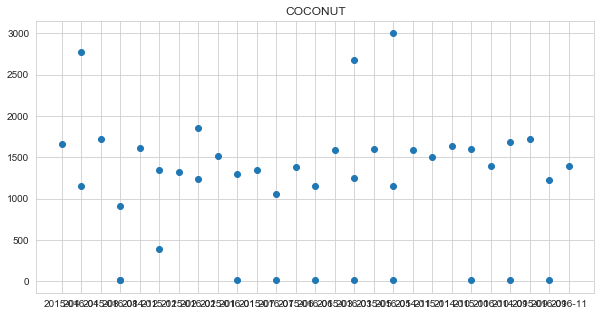

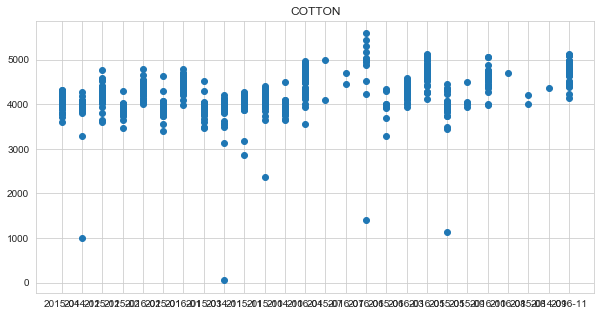

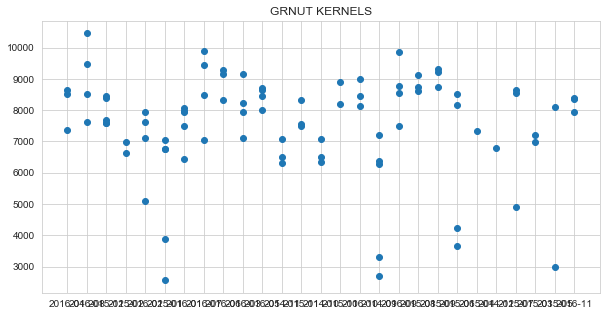

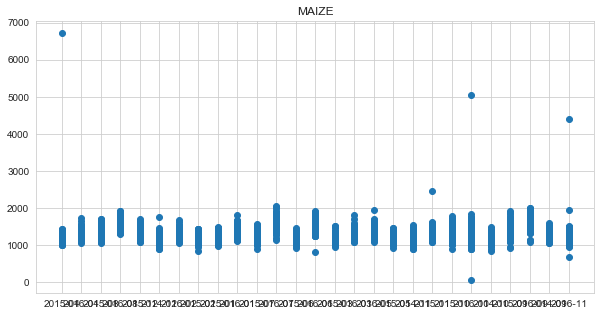

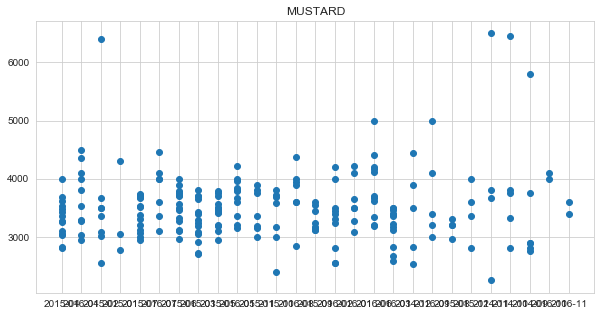

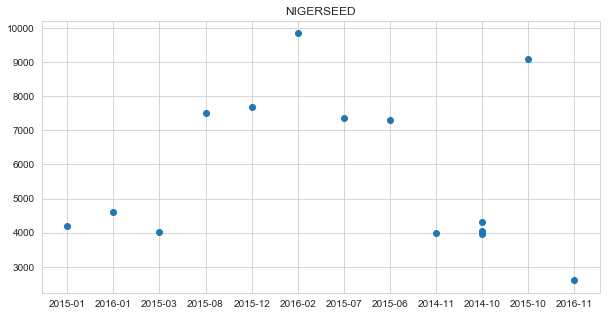

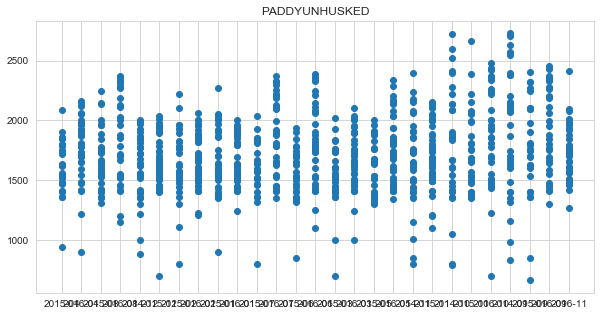

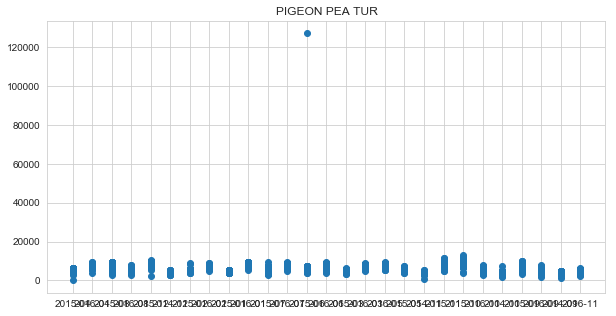

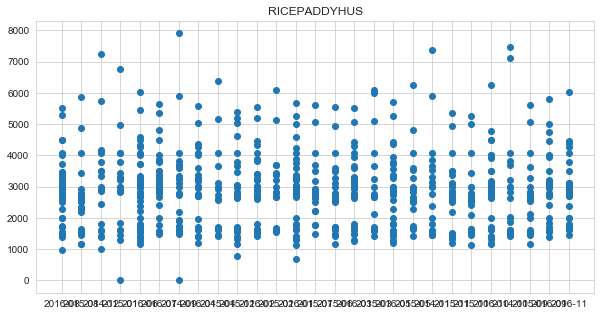

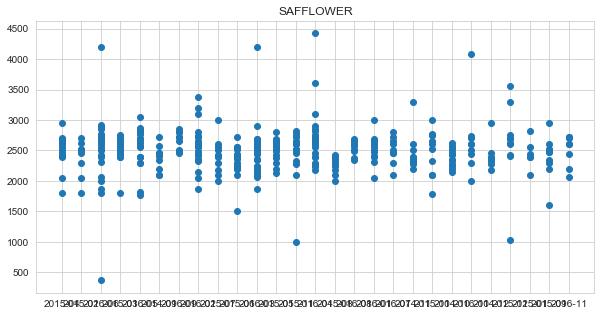

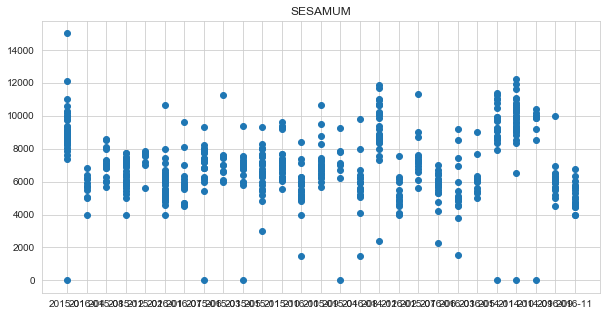

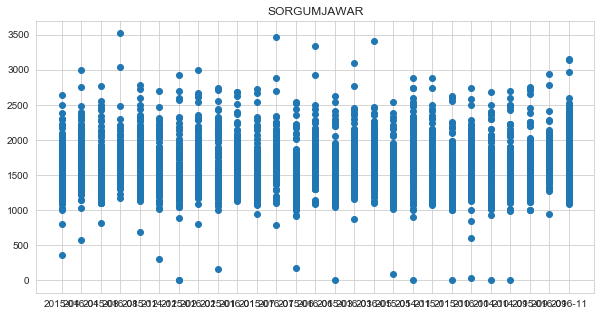

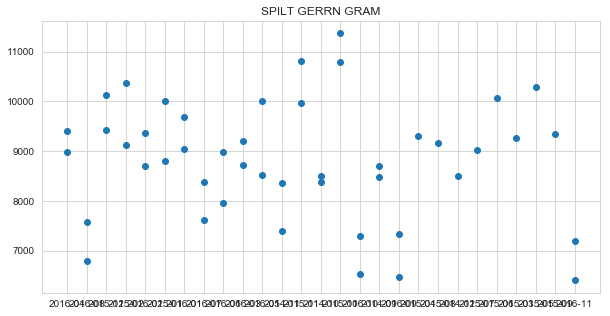

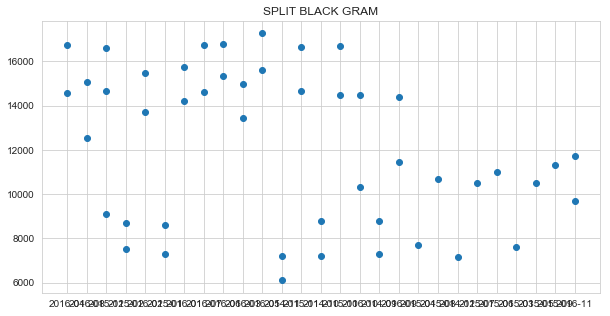

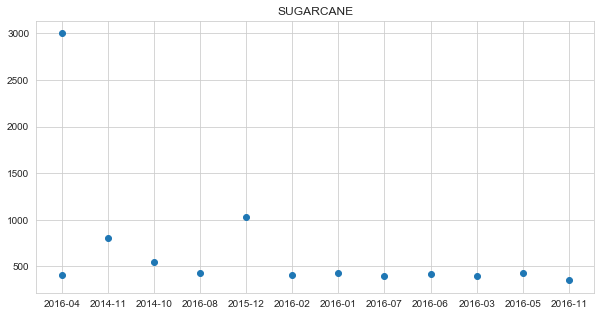

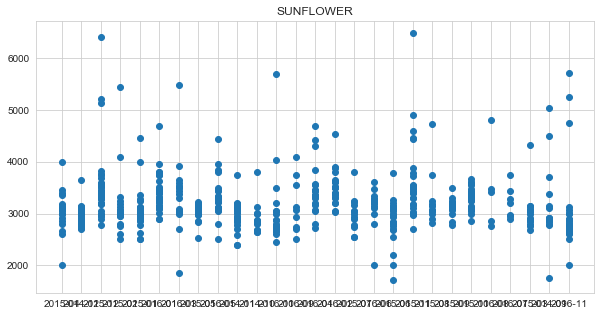

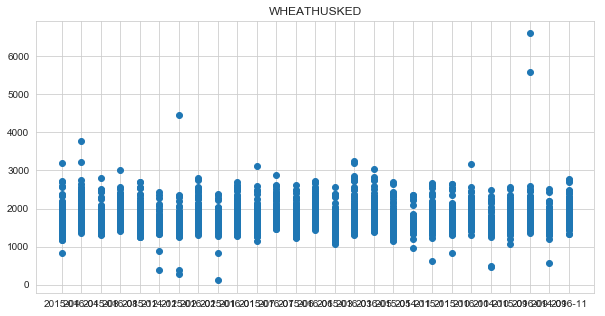

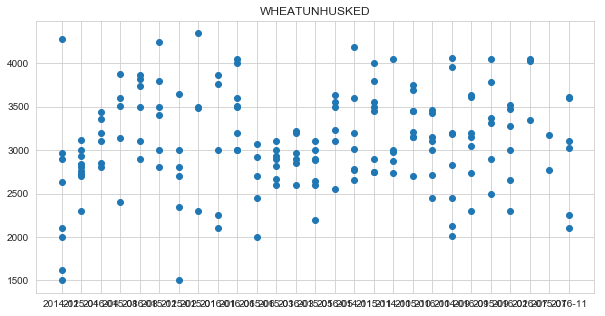

In [843]:
rcParams['figure.figsize'] = 10, 5
for i in range(len(common_commodities)):
    plt.figure()
    plt.title(common_commodities[i])
    #plt.subplot(10,10,10)
    plt.scatter(
        x= monthly_df.loc[monthly_df['Commodity'] == common_commodities[i]].date,
        y= monthly_df.loc[monthly_df['Commodity'] == common_commodities[i]].modal_price,
        
    ) 
    

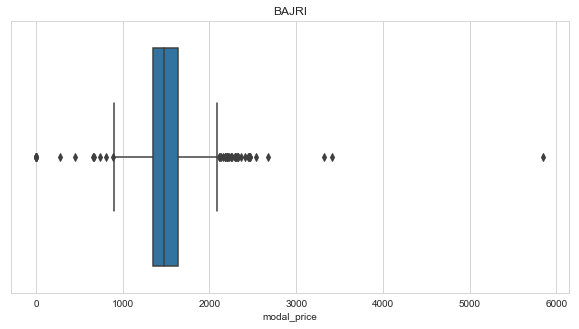

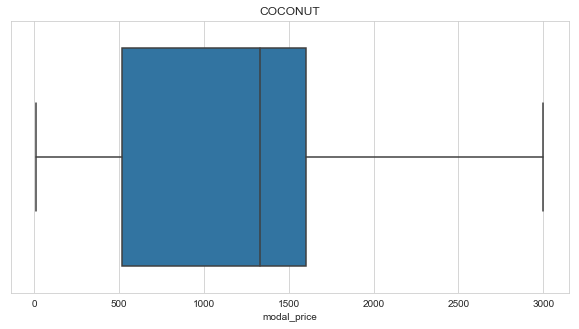

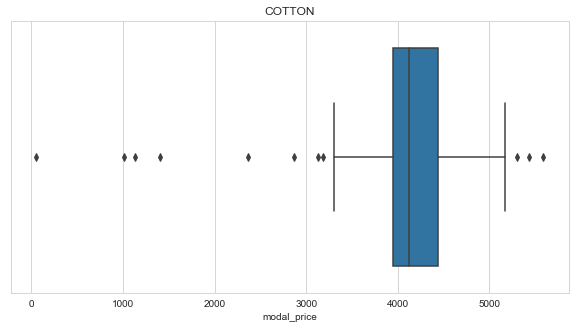

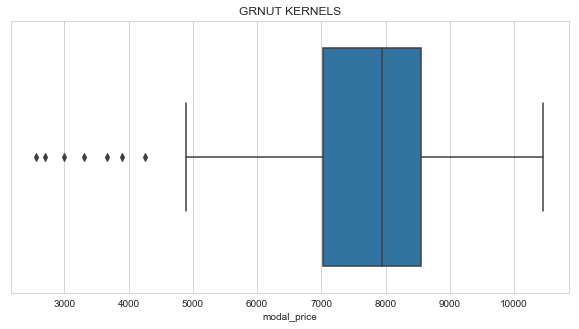

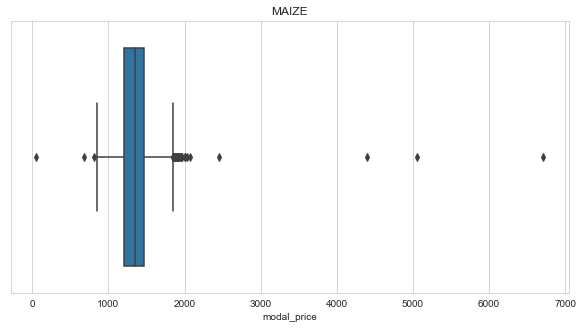

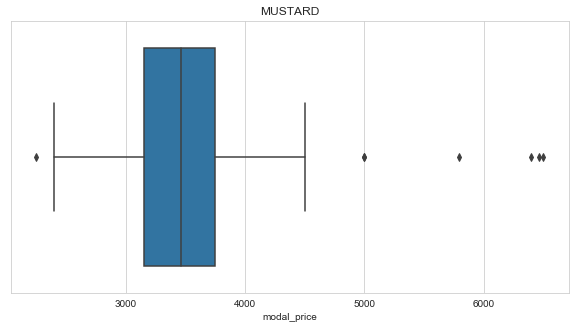

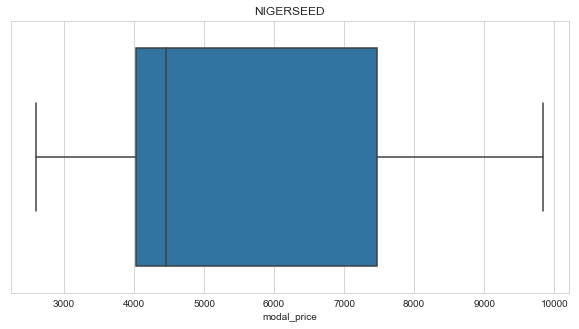

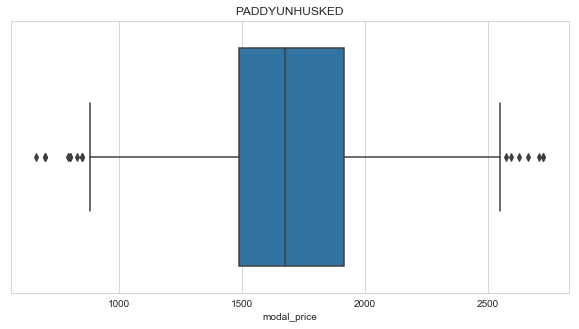

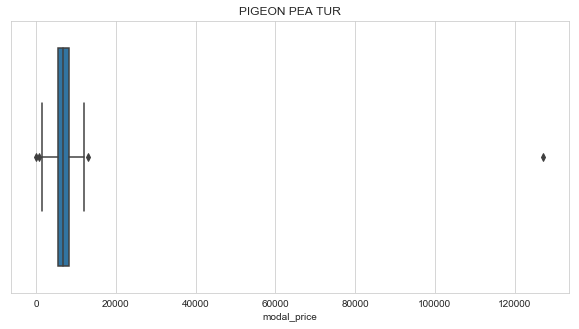

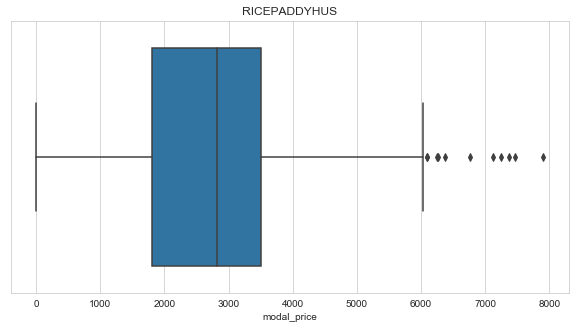

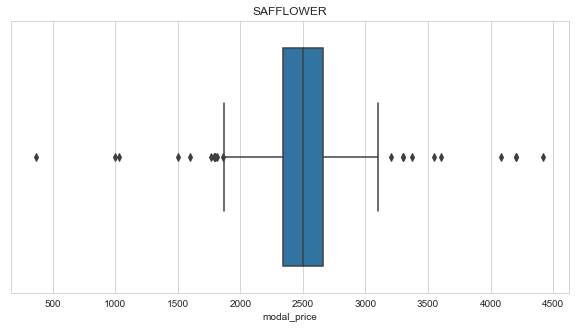

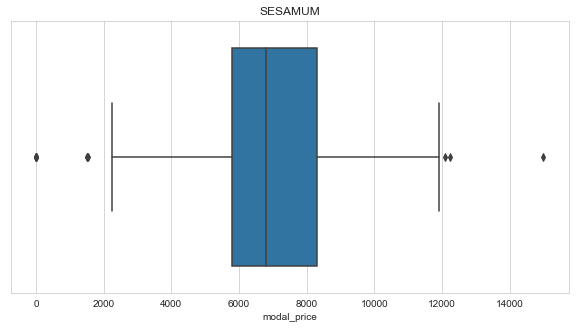

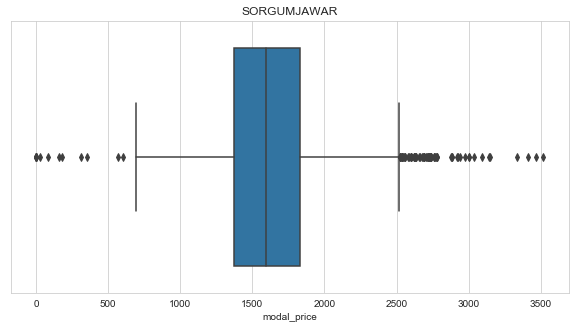

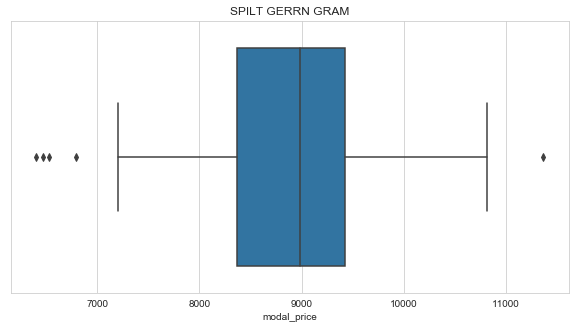

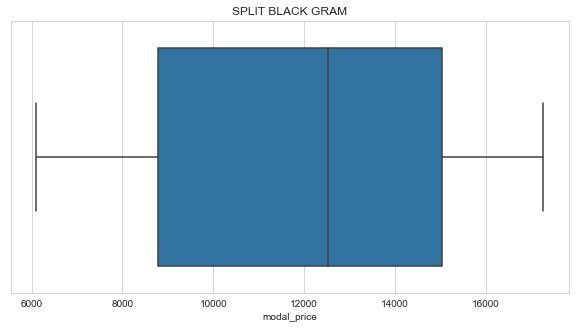

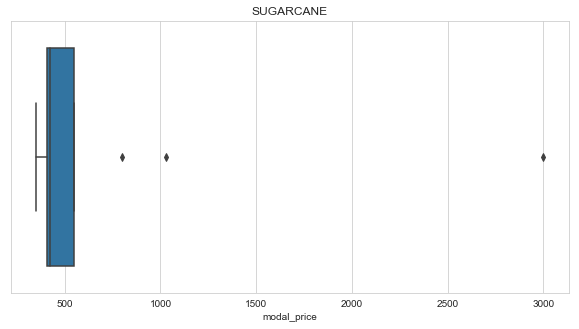

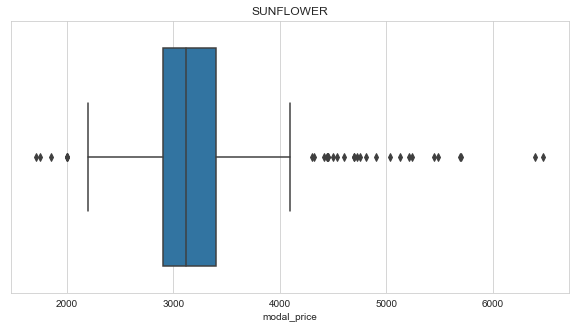

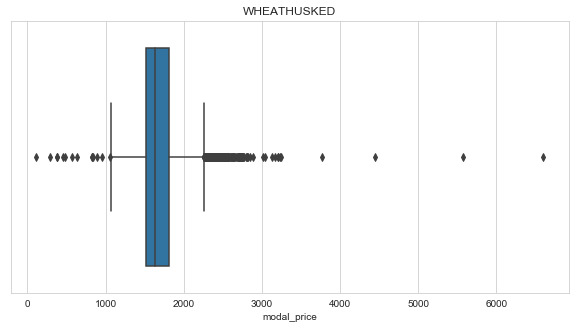

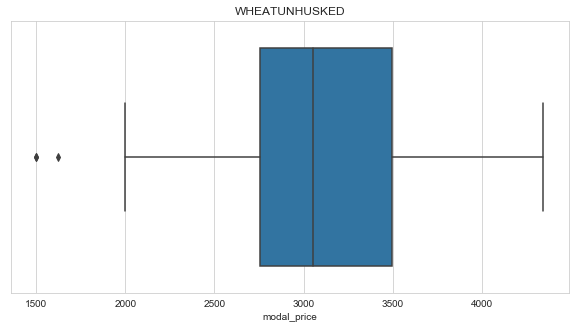

In [844]:
for i in range(len(common_commodities)):
    plt.figure()
    plt.title(common_commodities[i])
    #plt.subplot(10,10,10)
    sns.boxplot(
        #x= monthly_df.loc[monthly_df['Commodity'] == common_commodities[i]].date,
        x= monthly_df.loc[monthly_df['Commodity'] == common_commodities[i]].modal_price,
        
    ) 

In [629]:
#Now for removing the outliers we need to handle each of the commodity seperatly

In [630]:
monthly_df_Bajra = monthly_df.loc[monthly_df['Commodity'].isin(['BAJRI'])]

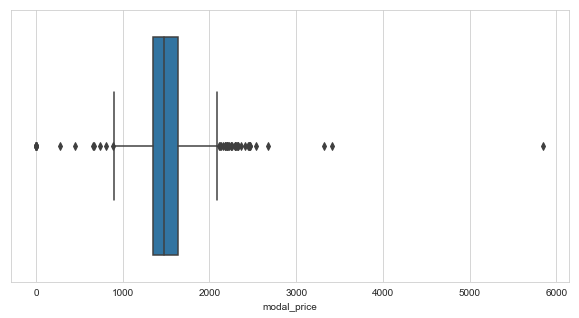

In [631]:
rcParams['figure.figsize'] = 10, 5
sns.boxplot(x=monthly_df_Bajra['modal_price'])

Text(0, 0.5, 'Modal Prices')

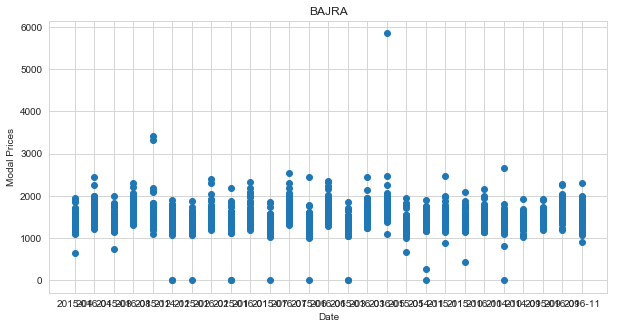

In [632]:
rcParams['figure.figsize'] = 10, 5
plt.scatter(x=monthly_df_Bajra['date'] , y=monthly_df_Bajra['modal_price'])
plt.title('BAJRA')
plt.xlabel('Date')
plt.ylabel("Modal Prices")

Now for removing outlier we can use the method of Mean and Standard deviation where the value must
lie between 3 standarad deviation from the mean we can clearly see this in the Normal Distribution curve
but this is valid only when our data is has normal Distribution
Although we can see from the graph the dataset of Bajra prices is nearly a normal curve

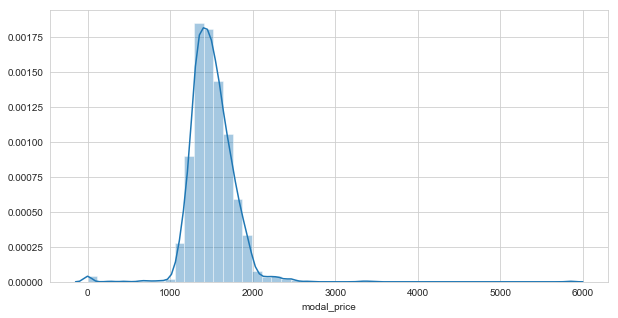

In [634]:
sns.distplot(monthly_df_Bajra['modal_price'])

In [633]:
monthly_df_Bajra_out_mean = monthly_df_Bajra[~(np.abs(monthly_df_Bajra['modal_price']-monthly_df_Bajra['modal_price'].mean()) > (3*monthly_df_Bajra['modal_price'].std()))]

Text(0, 0.5, 'Modal Prices')

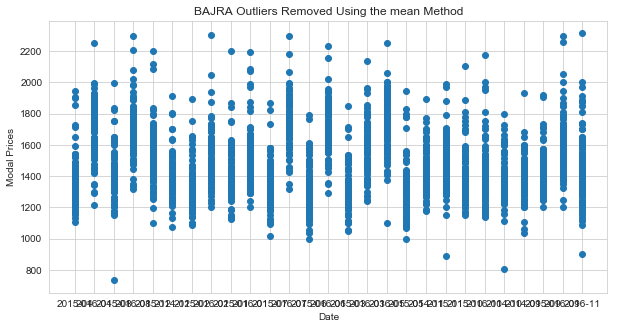

In [635]:
rcParams['figure.figsize'] = 10, 5
plt.scatter(x=monthly_df_Bajra_out_mean['date'] , y=monthly_df_Bajra_out_mean['modal_price'])
plt.title('BAJRA Outliers Removed Using the mean Method')
plt.xlabel('Date')
plt.ylabel("Modal Prices")

Another we to remove the outlier is to use the **Inter Quartile Range(IQR) Method** where in this method the data must lie between the lower bound i.e 25 percentile of the dataset and upper bound the 75 percentile in the dataset


For the clear visualzation we see the boxplot plotted above for understanding the quatile range , the middle value os the median

In [636]:
#Calculating the IQR
Q1 = monthly_df_Bajra.modal_price.quantile(0.25)
Q3 = monthly_df_Bajra.modal_price.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

298.0


In [637]:
#Now eleiminating the data which is not in the range of the IQR
monthly_df_Bajra_out_IQR = monthly_df_Bajra[~((monthly_df_Bajra.modal_price < (Q1 - 1.5 * IQR)) |(monthly_df_Bajra.modal_price > (Q3 + 1.5 * IQR)))]

Text(0, 0.5, 'Modal Prices')

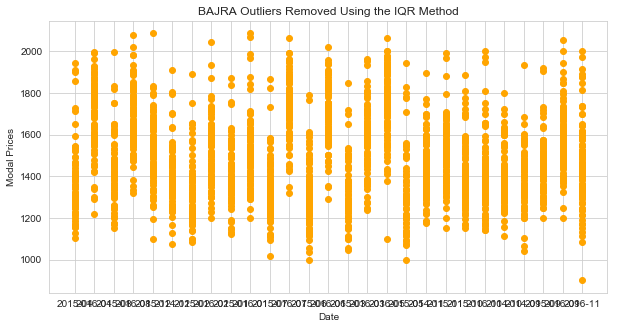

In [638]:
plt.scatter(
    x= monthly_df_Bajra_out_IQR.date,
    y= monthly_df_Bajra_out_IQR.modal_price,
    color='orange'
)
plt.title('BAJRA Outliers Removed Using the IQR Method')
plt.xlabel('Date')
plt.ylabel("Modal Prices")

Text(0, 0.5, 'Modal Prices')

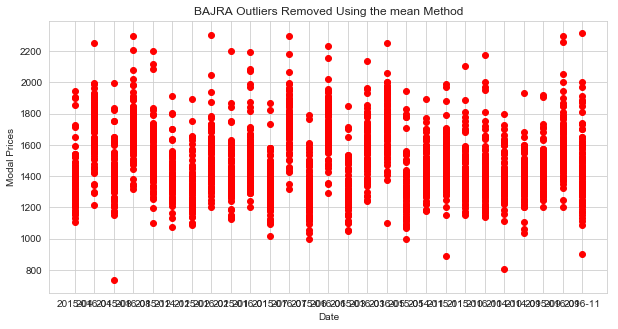

In [639]:
plt.scatter(x=monthly_df_Bajra_out_mean['date'] , y=monthly_df_Bajra_out_mean['modal_price'] ,color='red')
plt.title('BAJRA Outliers Removed Using the mean Method')
plt.xlabel('Date')
plt.ylabel("Modal Prices")

Although both the methods have the same intuition behind their working but we are getting better esults using the IQR Method
so we go forward with that method

In [845]:
#Now we can Simply iterate over each commodity and remove the outliers

In [846]:
#Seperating the dataframe based on each commodity

In [642]:
list_df={}
for i in range(len(common_commodities)):
    #plt.figure()
    #plt.title(common_commodities[i])
    list_df[i] = monthly_df.loc[monthly_df['Commodity'].isin([common_commodities[i]])]

In [848]:
#list_df has the values of seperated datframe created


In [645]:
#Calculating the IQR for each dataframe
Q1_list={}
Q3_list={}
IQR_list={}
for i in range(len(common_commodities)):
    
    Q1 = list_df[i].modal_price.quantile(0.25)
    Q3 = list_df[i].modal_price.quantile(0.75)
    Q1_list[i]=Q1
    Q3_list[i]=Q3
    IQR = Q3 - Q1
    IQR_list[i]=IQR
    #print(IQR)

In [644]:
#19 values corresponding to each commodity
IQR_list

{0: 298.0,
 1: 1084.25,
 2: 491.0,
 3: 1526.75,
 4: 255.75,
 5: 596.25,
 6: 3430.5,
 7: 424.0,
 8: 2714.0,
 9: 1700.0,
 10: 316.0,
 11: 2500.25,
 12: 458.0,
 13: 1051.5,
 14: 6242.5,
 15: 145.0,
 16: 500.0,
 17: 297.0,
 18: 740.5}

In [648]:
list_df_out={}
for i in range(len(common_commodities)):
    list_df_out[i] = list_df[i][~((list_df[i].modal_price < (Q1_list[i] - 1.5 * IQR_list[i])) |( list_df[i].modal_price > (Q3_list[i] + 1.5 * IQR_list[i])))]

In [647]:
#list_df_out has all the datasets with outliers removed

In [646]:
#Now concating the all the seprated dataframes into one final dataframe
df_final_out=pd.concat(list_df_out)

In [649]:
df_final_out.head()

APMC Commodity  Year  Month arrivals_in_qtl  min_price  max_price  \
0 0   AHMEDNAGAR     BAJRI  2015  APRIL              79       1406       1538   
  1   AHMEDNAGAR     BAJRI  2016  APRIL             106       1788       1925   
  51       AKOLE     BAJRI  2015  APRIL              52       1357       1800   
  52       AKOLE     BAJRI  2016  APRIL              75       1460       1960   
  64     JAMKHED     BAJRI  2015  APRIL             164       1304       1446   

      modal_price     date district_name   state_name  
0 0          1463  2015-04    AHMADNAGAR  MAHARASHTRA  
  1          1875  2016-04    AHMADNAGAR  MAHARASHTRA  
  51         1525  2015-04    AHMADNAGAR  MAHARASHTRA  
  52         1685  2016-04    AHMADNAGAR  MAHARASHTRA  
  64         1375  2015-04    AHMADNAGAR  MAHARASHTRA

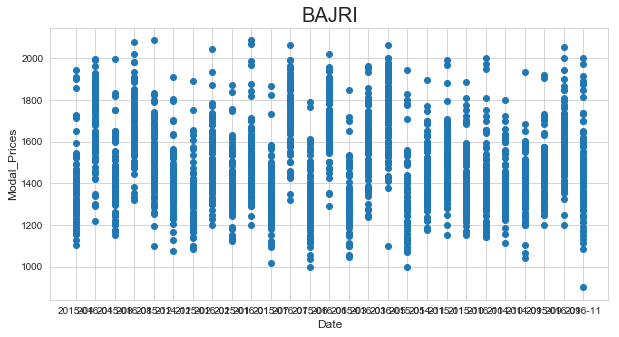

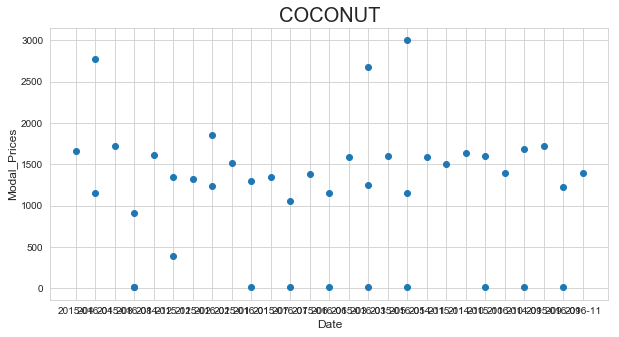

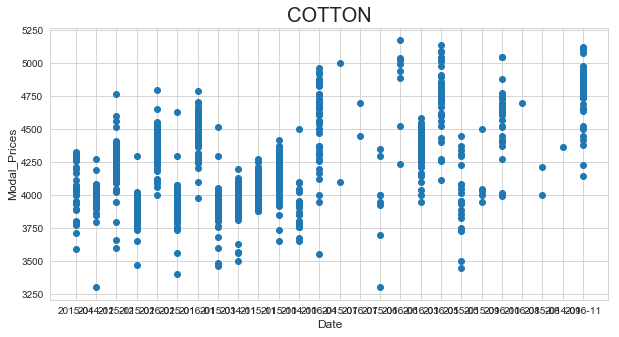

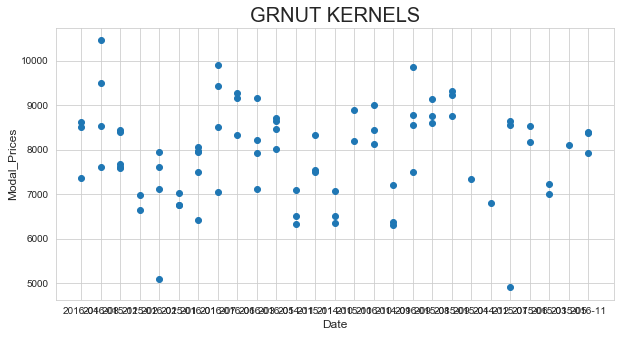

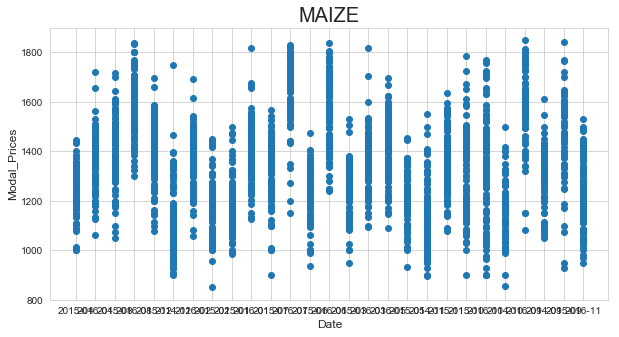

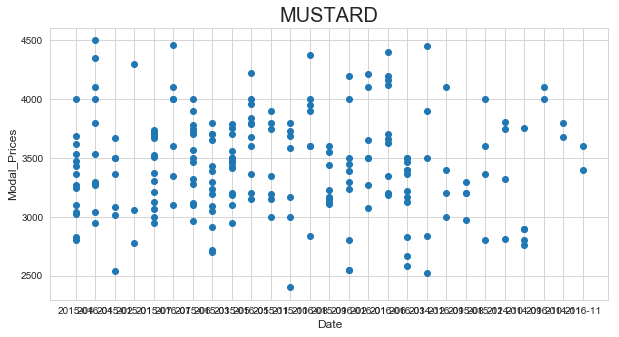

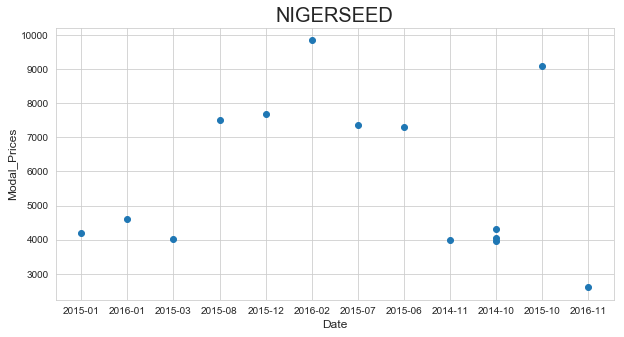

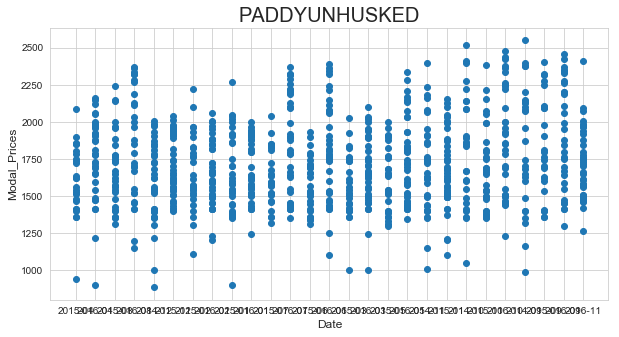

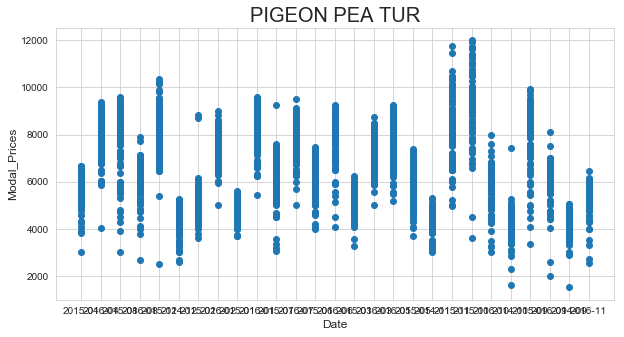

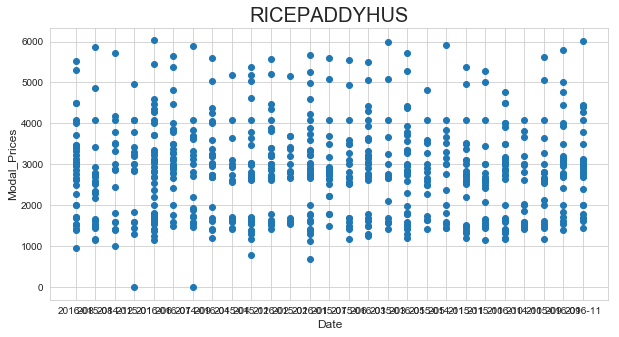

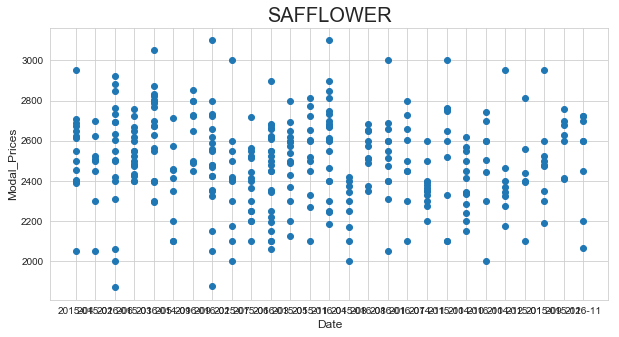

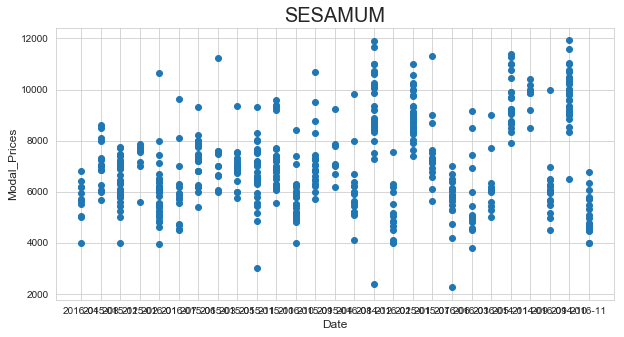

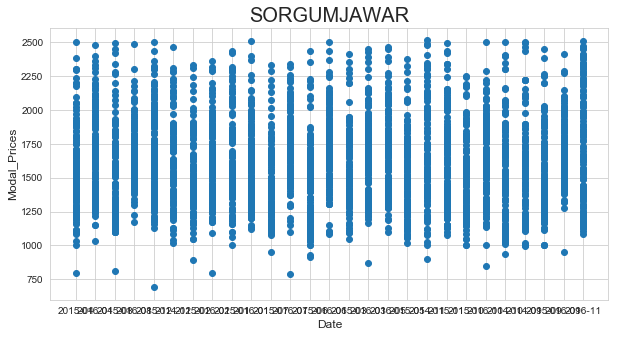

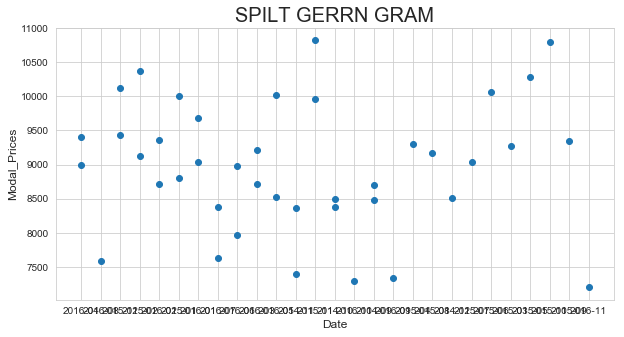

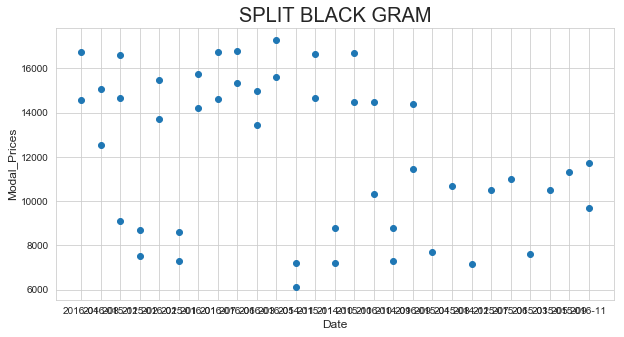

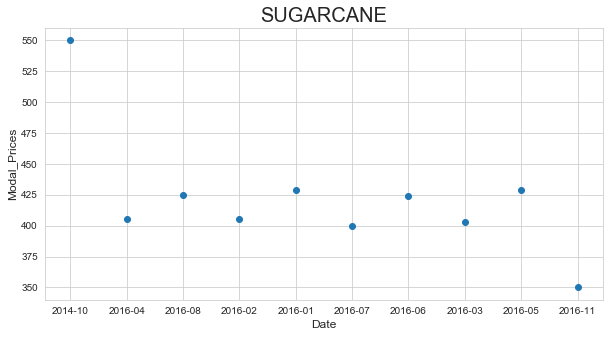

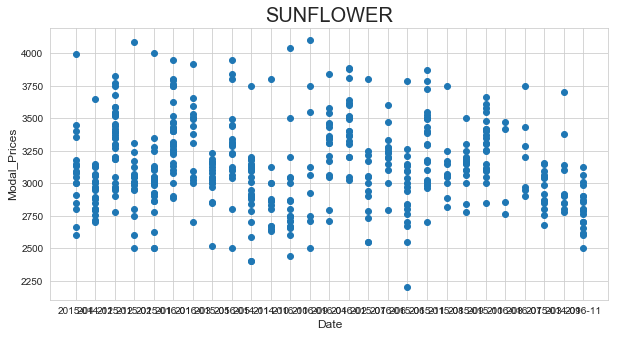

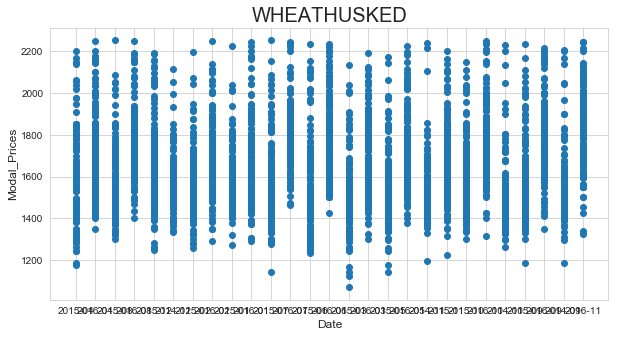

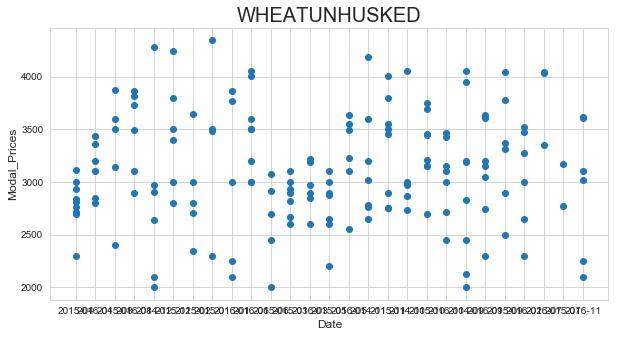

In [1042]:
rcParams['figure.figsize'] = 10, 5
for i in range(len(common_commodities)):
    plt.figure()

    
    plt.scatter(
        x= df_final_out.loc[df_final_out['Commodity'] == common_commodities[i]].date,
        y= df_final_out.loc[df_final_out['Commodity'] == common_commodities[i]].modal_price,
        #ax=axs[i]
        #figsize=(40,20)
    )
    #plt.legend(loc='best',fontsize=20)
    plt.title(common_commodities[i] , fontsize=20)
    plt.xlabel('Date',fontsize=12)
    plt.ylabel('Modal_Prices',fontsize=12)
    plt.savefig("OutliersRemoved{y}.png".format(y=common_commodities[i]))

Thus we can clearly see majority of the outliers from our datset have been removed we can now
continue with out EDA and complete the further tasks

In [651]:
#Saving the cleaned data in a seperate CSV final 
df_final_out.to_csv('Cleaned_APMC_monthly.csv')

In [653]:
monthly_df_out=df_final_out

In [652]:
monthly_df_out.head()

APMC Commodity  Year  Month arrivals_in_qtl  min_price  max_price  \
0 0   AHMEDNAGAR     BAJRI  2015  APRIL              79       1406       1538   
  1   AHMEDNAGAR     BAJRI  2016  APRIL             106       1788       1925   
  51       AKOLE     BAJRI  2015  APRIL              52       1357       1800   
  52       AKOLE     BAJRI  2016  APRIL              75       1460       1960   
  64     JAMKHED     BAJRI  2015  APRIL             164       1304       1446   

      modal_price     date district_name   state_name  
0 0          1463  2015-04    AHMADNAGAR  MAHARASHTRA  
  1          1875  2016-04    AHMADNAGAR  MAHARASHTRA  
  51         1525  2015-04    AHMADNAGAR  MAHARASHTRA  
  52         1685  2016-04    AHMADNAGAR  MAHARASHTRA  
  64         1375  2015-04    AHMADNAGAR  MAHARASHTRA

## Seasonality Detection 

Seasonality detection and treatment is done with the help of an illustrative example:

For interpretability, an analysis is performed on randomly chosen AMPC-Commodity combinations that consist of enough data points to conduct the time series analysis.

Only those groups which have atleast 24 observations are considered for an effective time series analysis.

Thus we have selected the the Commodity Bajri and APMC as Jalgaon

In [1063]:
df5_temp = monthly_df_out
df5_temp = df5_temp .loc[df5_temp['Commodity'].isin(['BAJRI']) & df5_temp['APMC'].isin(['JALGAON'])]

In [1064]:
#df5 = monthly_df
df5_test = monthly_df_out

df5_test = df5_test.loc[df5_test['Commodity'].isin(['BAJRI']) & df5_test['APMC'].isin(['JALGAON'])]

#df5_2014 = df5_2014.loc[df5_2014['APMC'].isin([''])]
#df5 = pd.DataFrame(df5.groupby(['date']).agg('mean')).reset_index()
df5_test = df5_test[['date', 'modal_price']]
df5_test.head()

date  modal_price
0 18787  2015-04         1346
  18788  2016-04         1784
  18986  2015-08         1356
  18987  2016-08         1788
  19165  2014-12         1398

In [1060]:
df5_test=df5_temp

In [1069]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')

df5_test = pd.read_csv('forecast_APMC_final.csv', parse_dates=['date'], index_col='date',date_parser=dateparse) # indexed the date column
df5_test = df5_test[['modal_price']]
df5_test

modal_price
date                   
2015-04-01         1346
2016-04-01         1784
2015-08-01         1356
2016-08-01         1788
2014-12-01         1398
2015-12-01         1525
2015-02-01         1314
2016-02-01         1425
2015-01-01         1390
2016-01-01         1475
2015-07-01         1286
2016-07-01         1800
2015-06-01         1153
2016-06-01         1729
2015-03-01         1266
2016-03-01         1655
2015-05-01         1119
2016-05-01         1788
2014-11-01         1422
2015-11-01         1467
2014-10-01         1350
2015-10-01         1372
2016-10-01         1515
2014-09-01         1406
2015-09-01         1405
2016-09-01         1719
2016-11-01         1439

In [1070]:
df5_test.index

DatetimeIndex(['2015-04-01', '2016-04-01', '2015-08-01', '2016-08-01',
               '2014-12-01', '2015-12-01', '2015-02-01', '2016-02-01',
               '2015-01-01', '2016-01-01', '2015-07-01', '2016-07-01',
               '2015-06-01', '2016-06-01', '2015-03-01', '2016-03-01',
               '2015-05-01', '2016-05-01', '2014-11-01', '2015-11-01',
               '2014-10-01', '2015-10-01', '2016-10-01', '2014-09-01',
               '2015-09-01', '2016-09-01', '2016-11-01'],
              dtype='datetime64[ns]', name='date', freq=None)

In [1071]:
df5_plot=df5_test

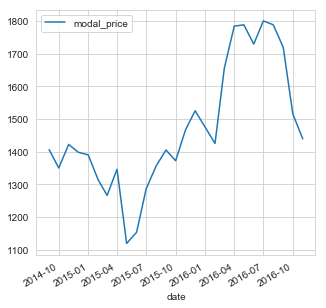

In [1072]:
df5_test.plot()


In [1073]:
data=np.array(df5_plot.iloc[:,0].values,dtype=float)
print(type(data))
index=df5_plot.index
timeser=pd.Series(data=data,index=index)

<class 'numpy.ndarray'>


In [1074]:
df5_plot.dtypes

modal_price    int64
dtype: object

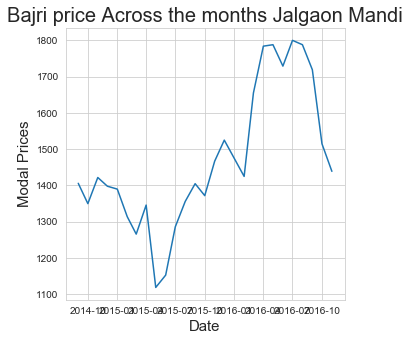

In [1076]:
rcParams['figure.figsize'] = 5, 5
sns.lineplot(x=df5_test.index,y=df5_test['modal_price'],data=df5_test)
plt.title('Bajri price Across the months Jalgaon Mandi',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Modal Prices',fontsize=15)
plt.savefig(' BajrijalgaonPrices')

Now from the above plot we can see the Fluctation in the Timeseries plot of Wheathusked and
thus we need to check whether our data is stationary or not

**The Intution behind making the Data Stationary**



We make the series stationary to make the variables independent. Variables can be dependent in various ways, but can only be independent in one way. So, we will get more information when they are independent. Hence the time series must be stationary.

If the time series is not stationary, firstly we have to make it stationary. For doing so, we need to remove the trend and seasonality from the data. 





       We use Dickey Fuller test to check the stationarity of the series.
       The intuition behind this test is that it determines how strongly a time series is defined by a trend.
       The null hypothesis of the test is that time series is not stationary (has some time-dependent structure).
       The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary. 

The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

In [838]:
#Creating a series Data for ease of visualization
data=np.array(df5_test.iloc[:,0].values,dtype=float)
print(type(data))
index=df5_test.index
timeser=pd.Series(data=data,index=index)

<class 'numpy.ndarray'>


**We can also plot the autocorrelation function (ACF) versus lag. That is to say, we plot how correlated each subsequent lag is with the original:**
    

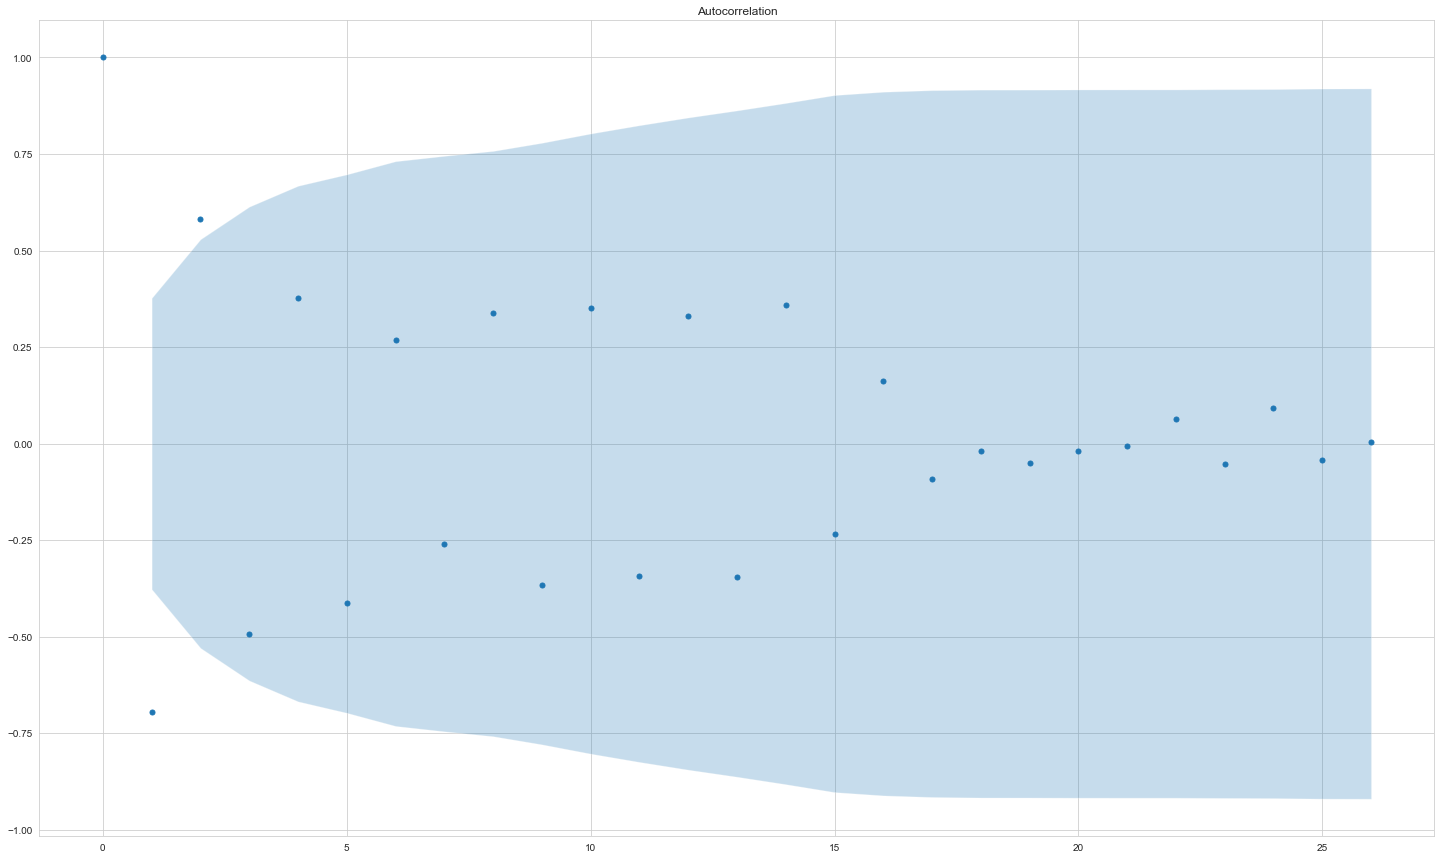

In [836]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig_first = plot_acf(timeser,use_vlines=False)

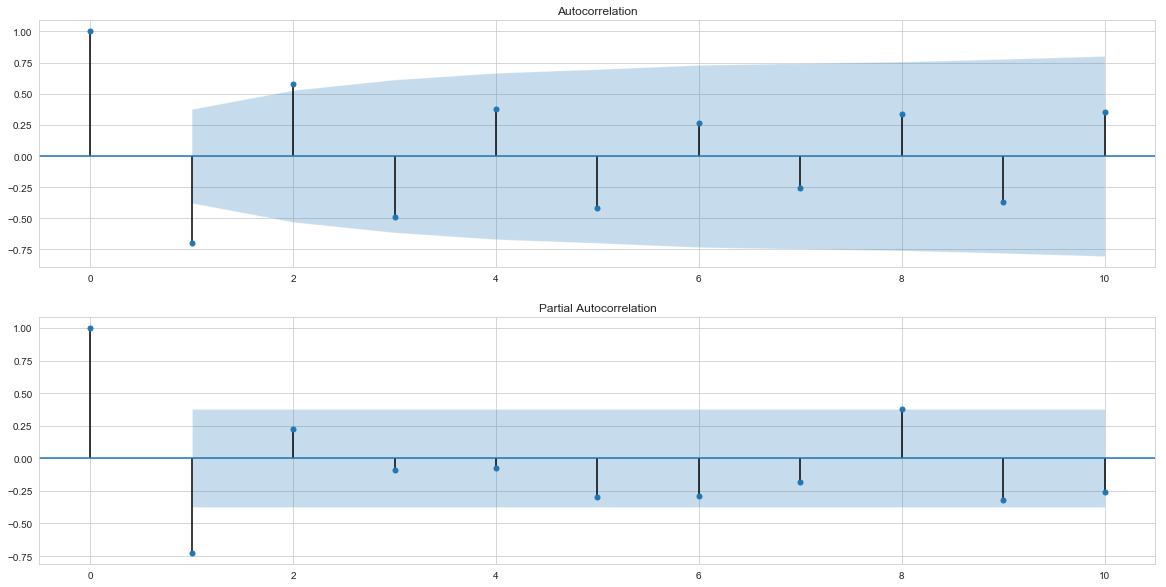

In [837]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(211)
fig = plot_acf(timeser, lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(timeser, lags=10, ax=ax2)

*It is clear that the autocorrelation is monotonically decreasing with time. This signifies that, at some time (t+n), there is still some relationship with the previous data points, (t+n-1), (t+n-2), through to initial time (t), with a large autocorrelation up until n=5 lag gaps. Therefore, we conclude that some time-dependent pattern seems to exist within this time series.*

In [661]:
from statsmodels.tsa.stattools import adfuller
# Store in a function for later use!
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [662]:
adf_check(df5_test['modal_price'])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.263712125846997
p-value : 0.6456063045052095
#Lags Used : 4
Number of Observations Used : 22
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


### Removing the Seasonality and Trend

Any given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.
These components are defined as follows:

*Level: The average value in the series.*

*Trend: The increasing or decreasing value in the series.*

*Seasonality: The repeating short-term cycle in the series.*

*Noise: The random variation in the series.*

A series is thought to be an aggregate or combination of these four components.
All series have a level and noise. The trend and seasonality components are optional.

It is helpful to think of the components as combining either additively or multiplicatively.



**Additive Model**
An additive model suggests that the components are added together as follows:

*y(t) = Level + Trend + Seasonality + Noise*

An additive model is linear where changes over time are consistently made by the same amount.





**Multiplicative Model**
A multiplicative model suggests that the components are multiplied together as follows:


*y(t) = Level * Trend * Seasonality * Noise*

A multiplicative model is nonlinear, such as quadratic or exponential. Changes increase or decrease over time.

A nonlinear trend is a curved line.

A non-linear seasonality has an increasing or decreasing frequency and/or amplitude over time.

### Directly Decomposing the Model using the statsmodel library's seasonal_decompose function

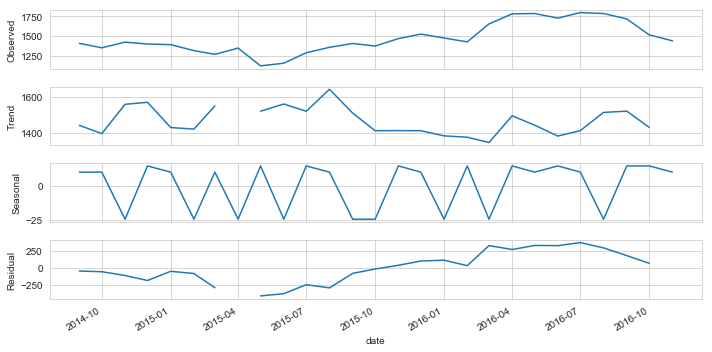

<Figure size 720x360 with 0 Axes>

In [851]:
from pandas import Series
from matplotlib import pyplot 
from statsmodels.tsa.seasonal import seasonal_decompose
#series = Series.from_csv('forecast_APMC.csv', header=0)
#groups = 
result_a = seasonal_decompose(timeser, model='additive',freq=3)

result_a.plot()
pyplot.show()
pyplot.savefig('DecompositionAdditive.jpg')

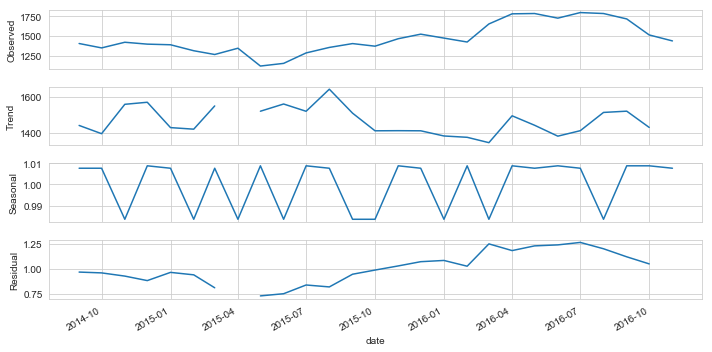

<Figure size 720x360 with 0 Axes>

In [852]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
#series = Series.from_csv('forecast_APMC.csv', header=0)
#groups = 
result_m = seasonal_decompose(timeser, model='multiplicative',freq=3)

result_m.plot()
pyplot.show()
pyplot.savefig('DecompositionMultiplicative.jpg')

Now we can clearly see that the above seasonal_decomposition on a frequency of 3 months which very clear from
the plot of wheathusked prices that prcies are fluctuating after every 3 months

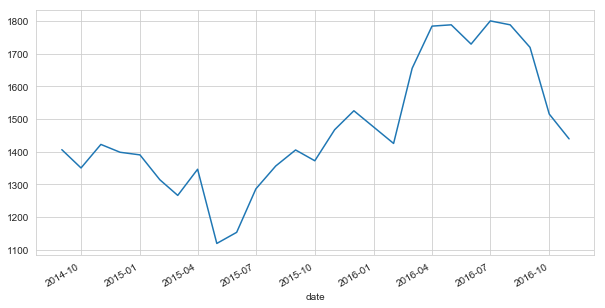

In [693]:
timeser.plot()

**From the Above Decomposition plots it is clearly our datset has Seasonality and a strong trend Line**

A seasonal trend cycle repeating itself after 3 months 

### Now first Considering the Additive Decomposition Model

In [ ]:
#for seasonal decomposition we use the diffrencing  method

We can difference the dataset manually.

This involves developing a new function that creates a differenced dataset. The function would loop through a provided series and calculate the differenced values at the specified interval or lag.

The simplest approach to determining if there is an aspect of seasonality is to plot and review your data, perhaps at different scales and with the addition of trend lines.

**We Apply the difference() function to our seasonal dataset**

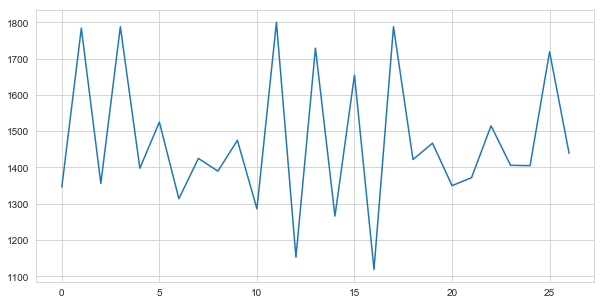

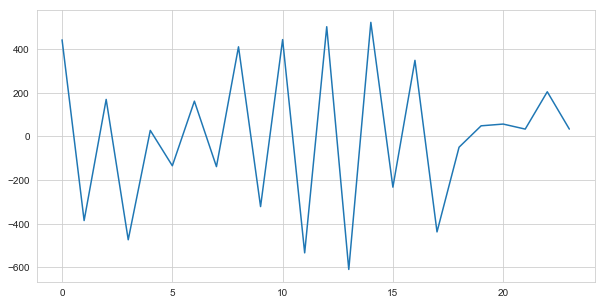

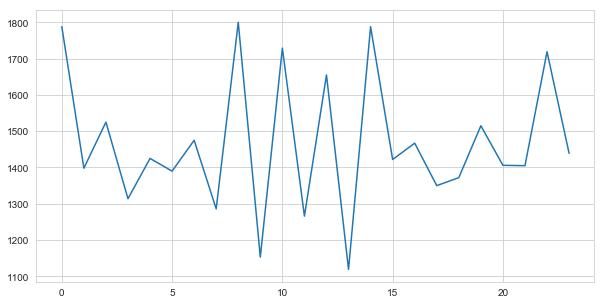

In [695]:

from math import sin
from math import radians
from matplotlib import pyplot

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced forecast
def inverse_difference(last_ob, value):
	return value + last_ob

# define a dataset with a linear trend
#data = [sin(radians(i)) for i in range(360)] + [sin(radians(i)) for i in range(360)]
pyplot.plot(data)
pyplot.show()
# difference the dataset
diff = difference(data, 3)
pyplot.plot(diff)
pyplot.show()
# invert the difference
inverted = [inverse_difference(data[i], diff[i]) for i in range(len(diff))]
pyplot.plot(inverted)
pyplot.show()

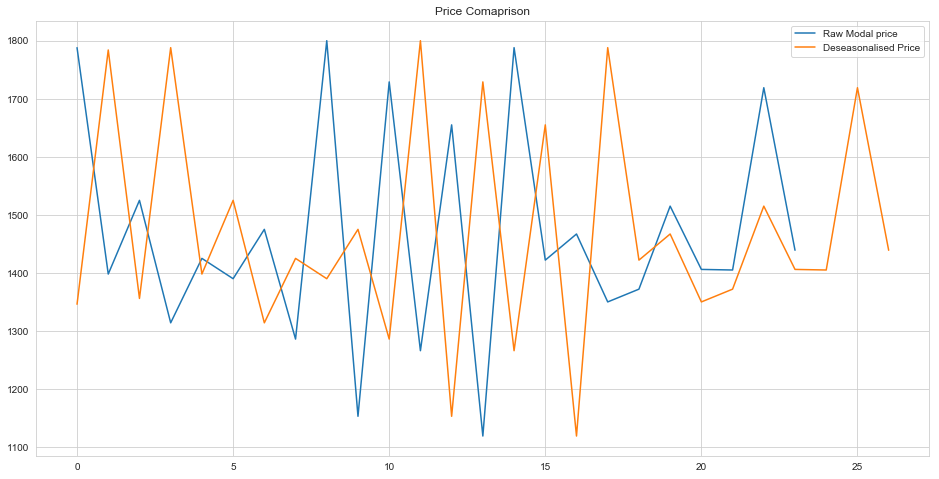

In [696]:
plt.figure(figsize=(16,8))
pyplot.plot(inverted , label = 'Raw Modal price')
pyplot.plot(timeser.values , label = 'Deseasonalised Price')
plt.title("Price Comaprison")
plt.legend(loc='best')

**We can clearly see the differencing method is cannot completly remove the seasonality from our data
Thus we will go about creating our own seasonal Decompose function which similar to the statsmodel's seasonal_decompose**

**The decompose() function is defined on the working behind the original seasonal_decompose function**

## Our own Seasonal Decompose Function to get the deasoanlised data

In [854]:
def decompose(df, period=365, lo_frac=0.6, lo_delta=0.01):
    """Create a seasonal-trend (with Loess, aka "STL") decomposition of observed time series data.
    This implementation is modeled after the ``statsmodels.tsa.seasonal_decompose`` method 
    but substitutes a Lowess regression for a convolution in its trend estimation.
    
    This is an additive model, Y[t] = T[t] + S[t] + e[t]        
    For more details on lo_frac and lo_delta, see: 
    
    `statsmodels.nonparametric.smoothers_lowess.lowess()`
    
    Args:
        df (pandas.Dataframe): Time series of observed counts. This DataFrame must be continuous (no 
            gaps or missing data), and include a ``pandas.DatetimeIndex``.  
        period (int, optional): Most significant periodicity in the observed time series, in units of
            1 observation. Ex: to accomodate strong annual periodicity within years of daily 
            observations, ``period=365``. 
       
       
    Returns:
        `statsmodels.tsa.seasonal.DecomposeResult`: An object with DataFrame attributes for the 
            seasonal, trend, and residual components, as well as the average seasonal cycle. 
    """
    # use some existing pieces of statsmodels    
    lowess = sm.nonparametric.lowess
    _pandas_wrapper, _ = _maybe_get_pandas_wrapper_freq(df)

    # get plain np array
    observed = np.asanyarray(df).squeeze()

    # calc trend, remove from observation
    trend = lowess(observed, [x for x in range(len(observed))], 
                   frac=lo_frac, 
                   delta=lo_delta * len(observed),
                   return_sorted=False)
    detrended = observed - trend

    # period must not be larger than size of series to avoid introducing NaNs
    period = min(period, len(observed))

    # calc one-period seasonality, remove tiled array from detrended
    period_averages = np.array([pd_nanmean(detrended[i::period]) for i in range(period)])
    # 0-center the period avgs
    period_averages -= np.mean(period_averages)
    seasonal = np.tile(period_averages, len(observed) // period + 1)[:len(observed)]    
    resid = detrended - seasonal
    deseasonalised = observed - seasonal

    # convert the arrays back to appropriate dataframes, stuff them back into 
    #  the statsmodel object
    results = list(map(_pandas_wrapper, [seasonal, trend, resid, observed,deseasonalised]))    
    dr = DecomposeResult(seasonal=results[0],
                         trend=results[1],
                         resid=results[2], 
                         observed=results[3],
                         deseasonalised=results[4],
                         period_averages=period_averages)
    return dr

In [855]:
result_additive=decompose(df5_test,period=3)

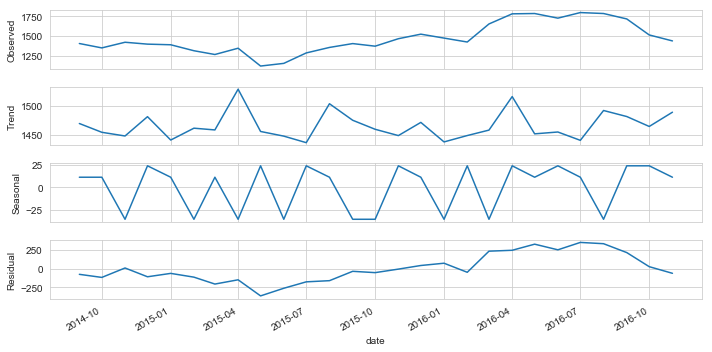

<Figure size 720x360 with 0 Axes>

In [856]:
result_additive.plot()
plt.show()
plt.savefig("My Decompose Results Add.jpg")

**Now we can clearly see the graph is completly similar 
to the one obtained from the seasonal_decompose function of the stats model**

In [ ]:
#Now creating a seperate dataset with only the modal prices 
#and the deasonalised prices for the particular APMC and Commodity cluster selected

In [709]:
deseasonalised_data=np.array(result_additive[4].values,dtype=float)

#index=result_additive.index
#timeser=pd.Series(data=data,index=index)

In [710]:
df5_deses = pd.read_csv('forecast_APMC_final.csv', parse_dates=['date'], index_col='date',date_parser=dateparse) # indexed the date column
df5_deses = df5_test[['modal_price']]
df5_deses

modal_price
date                   
2015-04-01         1346
2016-04-01         1784
2015-08-01         1356
2016-08-01         1788
2014-12-01         1398
2015-12-01         1525
2015-02-01         1314
2016-02-01         1425
2015-01-01         1390
2016-01-01         1475
2015-07-01         1286
2016-07-01         1800
2015-06-01         1153
2016-06-01         1729
2015-03-01         1266
2016-03-01         1655
2015-05-01         1119
2016-05-01         1788
2014-11-01         1422
2015-11-01         1467
2014-10-01         1350
2015-10-01         1372
2016-10-01         1515
2014-09-01         1406
2015-09-01         1405
2016-09-01         1719
2016-11-01         1439

In [711]:
df5_deses['deseasonalised_prices']=deseasonalised_data

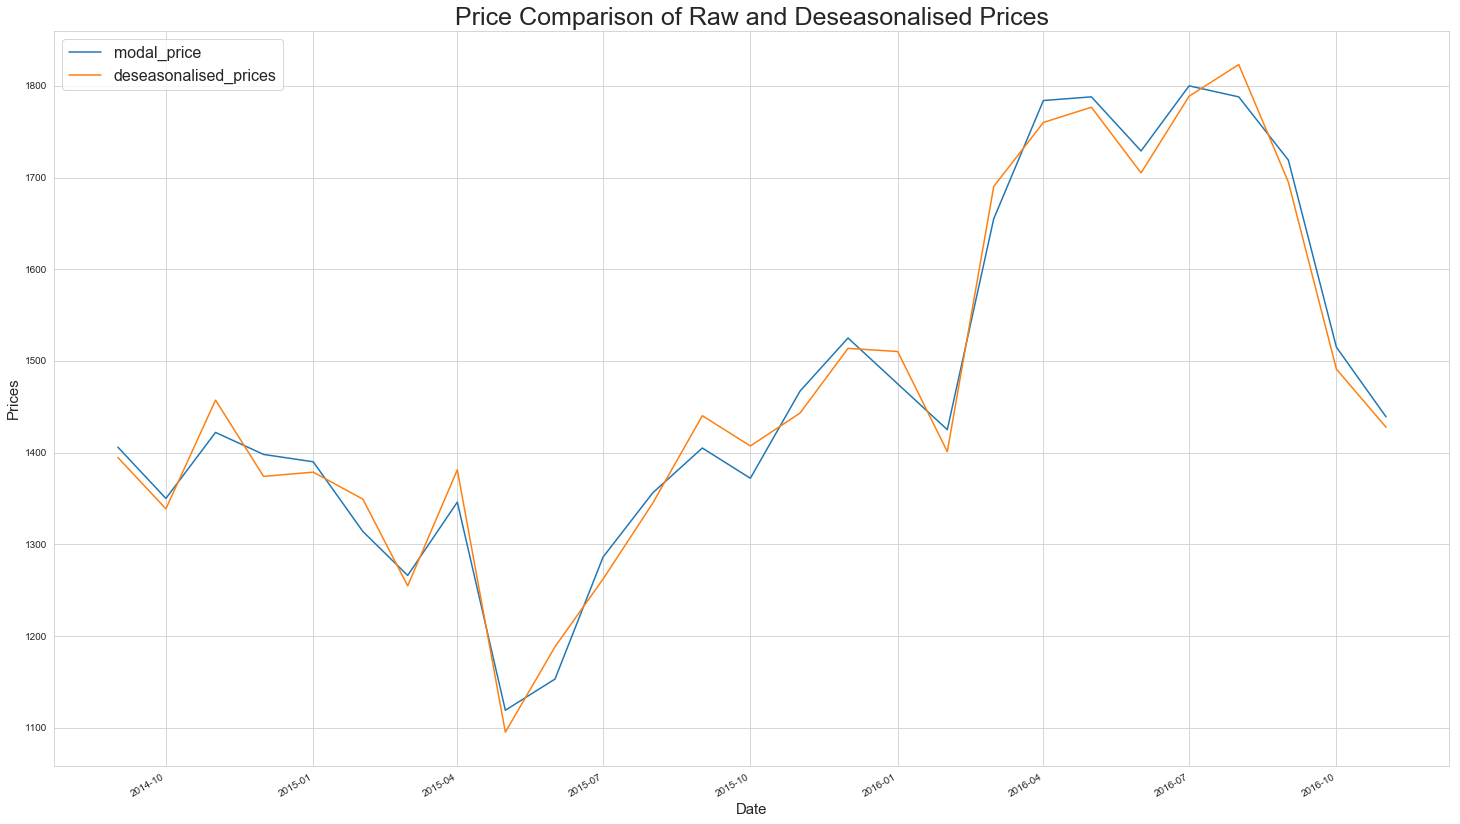

In [859]:
df5_deses.plot()
plt.legend(loc='best',fontsize=16)
plt.title('Price Comparison of Raw and Deseasonalised Prices' , fontsize=25)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Prices',fontsize=15)
rcParams['figure.figsize'] = 25, 15
#plt.figure(figsize(30,15))
plt.savefig('Comp Raw and Deseasonalised Add.jpg')

In [713]:
residuals_addtive=result_additive[2]


In [714]:
acf_additive=acf(residuals_addtive)
acf_additive

array([ 1.        , -0.75547925,  0.59417871, -0.53424385,  0.40537625,
       -0.41189071,  0.29245827, -0.24660257,  0.35915722, -0.39237836,
        0.36863215, -0.35937055,  0.32869562, -0.35920741,  0.37914541,
       -0.24302602,  0.18059943, -0.09060497, -0.01013176, -0.02593373,
       -0.00525428, -0.0125453 ,  0.06364698, -0.05642992,  0.0711714 ,
       -0.05056246,  0.01059969])

In [715]:
sum(acf_additive)

0.5000000000000001

### Now on the same grounds we can create the multiplicative model

In [860]:
def decompose_multiplicative(df, period=365):
    
    
    """Create a seasonal-trend (with Loess, aka "STL") decomposition of observed time series data.
    
    This implementation is modeled after the ``statsmodels.tsa.seasonal_decompose`` method 
    but substitutes a Lowess regression for a convolution in its trend estimation.
    
    This is a Multiplicative Model model, Y[t] = T[t] * S[t] * e[t]     
    
    For more details on lo_frac and lo_delta, see: 
    `statsmodels.nonparametric.smoothers_lowess.lowess()`
    
    Args:
        df (pandas.Dataframe): Time series of observed counts. This DataFrame must be continuous (no 
            gaps or missing data), and include a ``pandas.DatetimeIndex``.  
        period (int, optional): Most significant periodicity in the observed time series, in units of
            1 observation. Ex: to accomodate strong annual periodicity within years of daily 
            observations, ``period=365``. 
        
    Returns:
        `statsmodels.tsa.seasonal.DecomposeResult`: An object with DataFrame attributes for the 
            seasonal, trend, and residual components, as well as the average seasonal cycle. 
    """
    # use some existing pieces of statsmodels    
    lowess = sm.nonparametric.lowess
    _pandas_wrapper, _ = _maybe_get_pandas_wrapper_freq(df)

    # get plain np array
    observed = np.asanyarray(df).squeeze()

    # calc trend, remove from observation
    trend = lowess(observed, [x for x in range(len(observed))], 
                   
                   return_sorted=False)
    detrended = observed / trend

    # period must not be larger than size of series to avoid introducing NaNs
    period = min(period, len(observed))

    # calc one-period seasonality, remove tiled array from detrended
    period_averages = np.array([pd_nanmean(detrended[i::period]) for i in range(period)])
    # 0-center the period avgs
    period_averages /= np.mean(period_averages)
    seasonal = np.tile(period_averages, len(observed) // period + 1)[:len(observed)]    
    resid = detrended / seasonal
    deseasonalised = observed / seasonal

    # convert the arrays back to appropriate dataframes, stuff them back into 
    #  the statsmodel object
    results = list(map(_pandas_wrapper, [seasonal, trend, resid, observed,deseasonalised]))    
    dr = DecomposeResult(seasonal=results[0],
                         trend=results[1],
                         resid=results[2], 
                         observed=results[3],
                         deseasonalised=results[4],
                         period_averages=period_averages)
    return dr

In [861]:
result_multiplicative=decompose_multiplicative(df5_test,3)

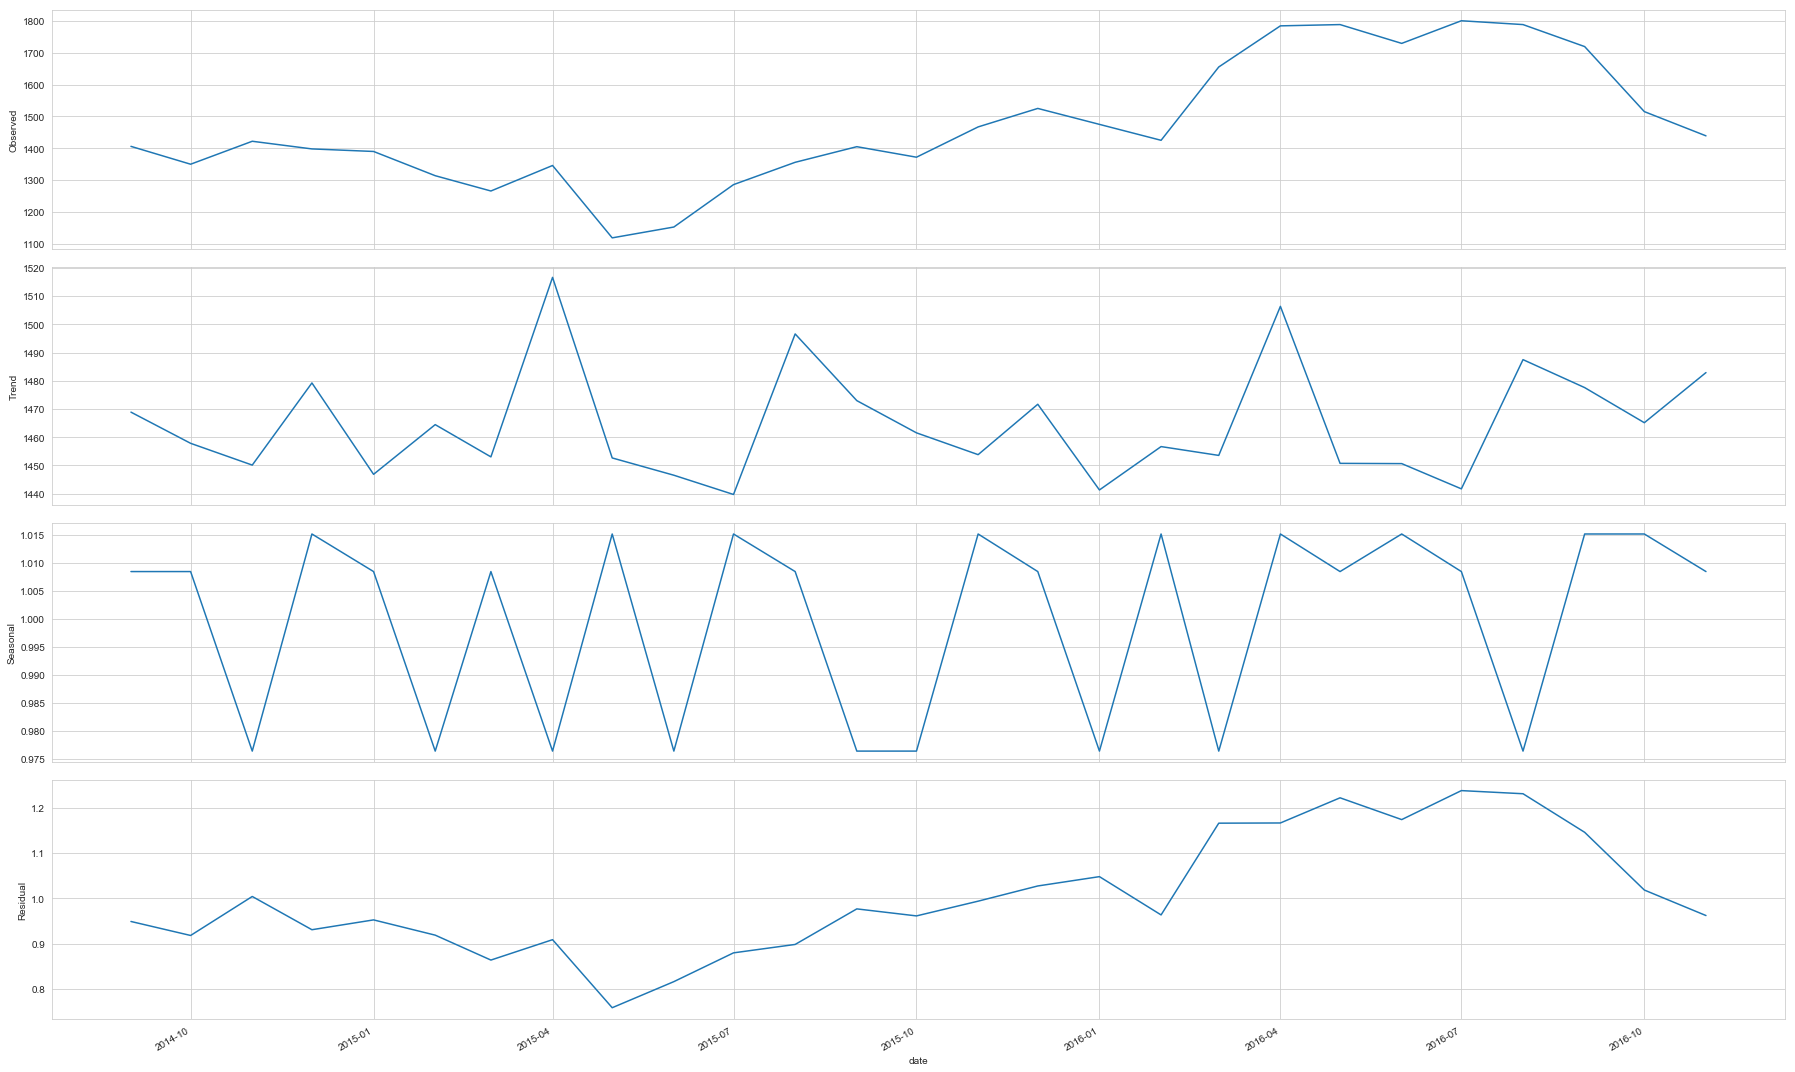

<Figure size 1800x1080 with 0 Axes>

In [862]:
result_multiplicative.plot()
plt.show()
plt.savefig("My Decompose Results Mult")

In [718]:
result_multiplicative_array=decompose_multiplicative(df5_test,3)

In [719]:
deseasonalised_data_m=np.array(result_multiplicative_array[4].values,dtype=float)


In [720]:
df5_deses_m = pd.read_csv('forecast_APMC8.csv', parse_dates=['date'], index_col='date',date_parser=dateparse) # indexed the date column
df5_deses_m = df5_test[['modal_price']]
df5_deses_m


modal_price
date                   
2015-04-01         1346
2016-04-01         1784
2015-08-01         1356
2016-08-01         1788
2014-12-01         1398
2015-12-01         1525
2015-02-01         1314
2016-02-01         1425
2015-01-01         1390
2016-01-01         1475
2015-07-01         1286
2016-07-01         1800
2015-06-01         1153
2016-06-01         1729
2015-03-01         1266
2016-03-01         1655
2015-05-01         1119
2016-05-01         1788
2014-11-01         1422
2015-11-01         1467
2014-10-01         1350
2015-10-01         1372
2016-10-01         1515
2014-09-01         1406
2015-09-01         1405
2016-09-01         1719
2016-11-01         1439

In [721]:
df5_deses_m['deseasonalised_prices']=deseasonalised_data_m

In [784]:
df5_deses_m

modal_price  deseasonalised_prices
date                                          
2015-04-01         1346            1378.581462
2016-04-01         1784            1757.331133
2015-08-01         1356            1344.626782
2016-08-01         1788            1831.280575
2014-12-01         1398            1377.101415
2015-12-01         1525            1512.209323
2015-02-01         1314            1345.806866
2016-02-01         1425            1403.697794
2015-01-01         1390            1378.341613
2016-01-01         1475            1510.704054
2015-07-01         1286            1266.775693
2016-07-01         1800            1784.902808
2015-06-01         1153            1180.909678
2016-06-01         1729            1703.153323
2015-03-01         1266            1255.381641
2016-03-01         1655            1695.061159
2015-05-01         1119            1102.272162
2016-05-01         1788            1773.003456
2014-11-01         1422            1456.421129
2015-11-01         1467            1445.069939
2014-10-01         1350            1338.677106
2015-10-01         1372            1405.210822
2016-10-01         1515            1492.352391
2014-09-01         1406            1394.207415
2015-09-01         1405            1439.009624
2016-09-01         1719            1693.302812
2016-11-01         1439            1426.930634

In [824]:
#Adding the deseasonalised prices coloumn to our dataset
df5_temp['deseasonalised_prices']=deseasonalised_data_m

In [825]:
#Saving the deseasonalised Prices in a Seperate File
df5_temp.to_csv('DeseasonalisedData.csv')

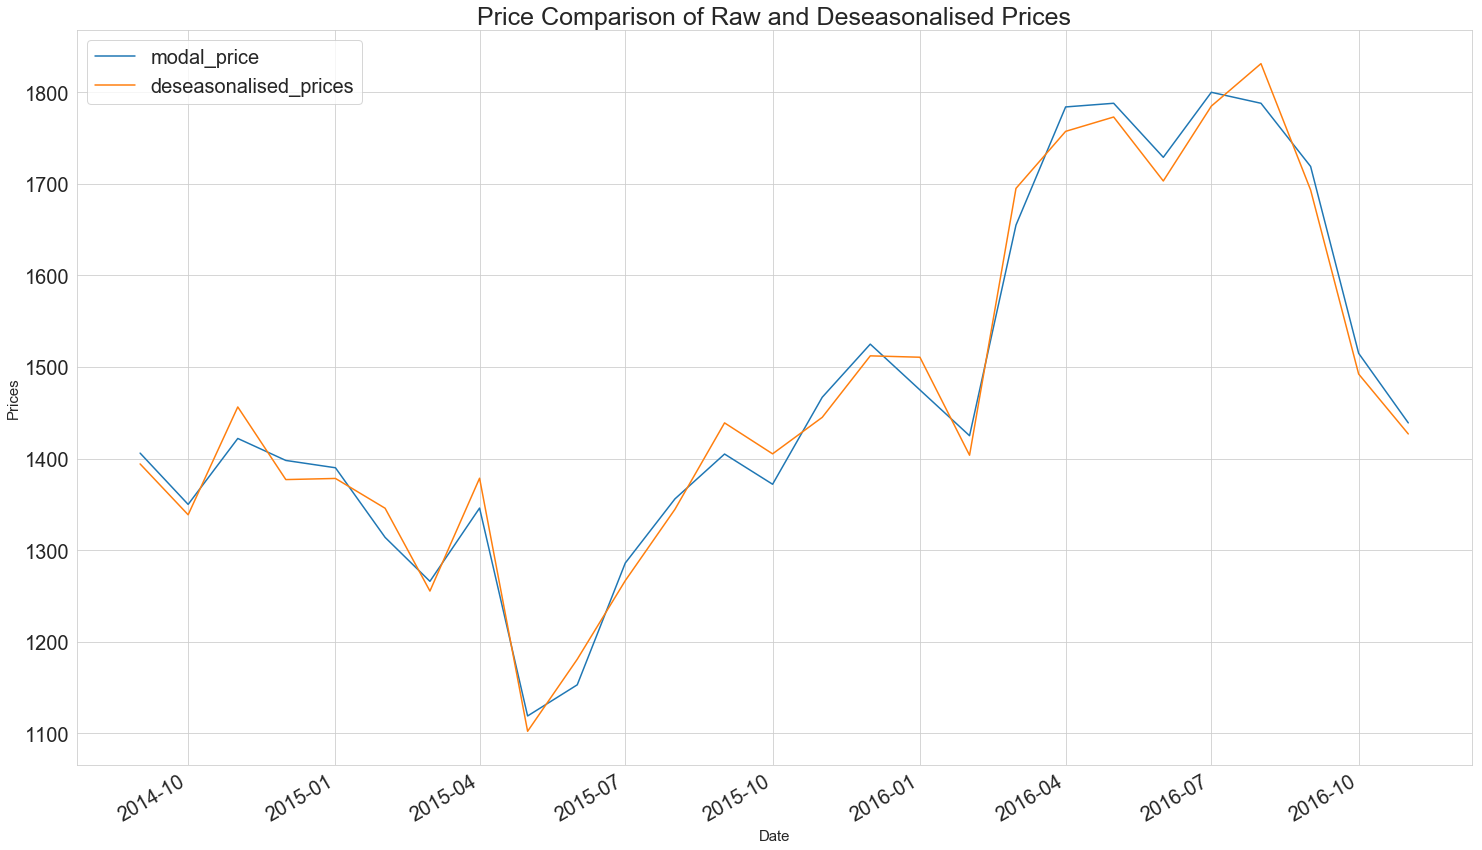

In [863]:
rcParams['figure.figsize'] = 25, 15
df5_deses_m.plot(fontsize=20)
plt.legend(loc='best',fontsize=20)
plt.title('Price Comparison of Raw and Deseasonalised Prices' , fontsize=25)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Prices',fontsize=15)
rcParams['figure.figsize'] = 25, 15
#plt.figure(figsize(30,15))
plt.savefig('Comp Raw and Deseasonalised Mult.jpg')

In [724]:
residuals_multiplicative=result_multiplicative_array[2]
acf_multiplicative=acf(residuals_multiplicative)
acf_multiplicative

array([ 1.        , -0.74643155,  0.59764504, -0.53401249,  0.4045979 ,
       -0.41840187,  0.2867989 , -0.25009599,  0.35581265, -0.38911308,
        0.36209292, -0.34984365,  0.32548534, -0.34891667,  0.37458797,
       -0.23196452,  0.17122852, -0.08845421, -0.01356304, -0.02778826,
       -0.00887915, -0.01190759,  0.06335622, -0.05350783,  0.06827646,
       -0.04588473,  0.00888269])

In [725]:

sum(acf_multiplicative)

0.4999999999999998

In [726]:
if(sum(acf_multiplicative) < sum(acf_additive)):
    print('Multiplicative Model')
else:
    print('Additive Model')

Multiplicative Model


## Function to check whether multiplicative or Additiva Model we need to compare the residuals of the multiplicative and addtive model so we compare their acf values and then decide over the model

In [730]:
def decompose_multiplicative_arr(df, period=365):
    
    # use some existing pieces of statsmodels    
    lowess = sm.nonparametric.lowess
    _pandas_wrapper, _ = _maybe_get_pandas_wrapper_freq(df)
    observed = np.asanyarray(df).squeeze()
    trend = lowess(observed, [x for x in range(len(observed))], 
                   
                   return_sorted=False)
    detrended = observed / trend
    period = min(period, len(observed))
    # calc one-period seasonality, remove tiled array from detrended
    period_averages = np.array([pd_nanmean(detrended[i::period]) for i in range(period)])
    # 0-center the period avgs
    period_averages /= np.mean(period_averages)
    seasonal = np.tile(period_averages, len(observed) // period + 1)[:len(observed)]    
    resid = detrended / seasonal
    deseasonalised = observed / seasonal
    results = list(map(_pandas_wrapper, [seasonal, trend, resid, observed,deseasonalised]))    
    return results

In [731]:
def decompose_additive_arr(df, period=365):
    
    # use some existing pieces of statsmodels    
    lowess = sm.nonparametric.lowess
    _pandas_wrapper, _ = _maybe_get_pandas_wrapper_freq(df)
    observed = np.asanyarray(df).squeeze()
    trend = lowess(observed, [x for x in range(len(observed))], 
                   
                   return_sorted=False)
    detrended = observed - trend
    period = min(period, len(observed))
    # calc one-period seasonality, remove tiled array from detrended
    period_averages = np.array([pd_nanmean(detrended[i::period]) for i in range(period)])
    # 0-center the period avgs
    period_averages -= np.mean(period_averages)
    seasonal = np.tile(period_averages, len(observed) // period + 1)[:len(observed)]    
    resid = detrended - seasonal
    deseasonalised = observed - seasonal
    results = list(map(_pandas_wrapper, [seasonal, trend, resid, observed,deseasonalised]))    
    return results

In [887]:
from statsmodels.tsa.stattools import acf
def checkModel(df):
    result_multiplicative_array=decompose_multiplicative_arr(df5_test,3)
    result_additive_array=decompose_additive_arr(df5_test,3)
    residuals_multiplicative=result_multiplicative_array[2]
    acf_multiplicative=acf(residuals_multiplicative)
    acf_multiplicative
    residuals_addtive=result_additive_array[2]
    acf_additive=acf(residuals_addtive)
    acf_additive
    if(sum(acf_multiplicative) <= sum(acf_additive)):
        print('Multiplicative Model')
        return 1
    else:
        print('Additive Model')
        return 0

In [888]:
checkModel(df5_test)

Multiplicative Model


1

*Thus from the above check it is very clear we need to use the Multiplicative Model*

## Function to get Deseasonalised Data

In [904]:
def deseasonalise_data(df,period):
        if(checkModel(df) ==1):
            print('Deseasonalising the Data using Multiplicative Model')
            result=decompose_multiplicative_arr(df,period)
            deseasonalised_data_m=np.array(result[4].values,dtype=float)
            df['deseasonalised_prices']=deseasonalised_data_m
        else:
            print('Deseasonalising the Data using Additive Model')
            result=decompose_additive_arr(df,period)
            deseasonalised_data_m=np.array(result[4].values,dtype=float)
            df['deseasonalised_prices']=deseasonalised_data_m
        return df

In [996]:
def deseasonalise_data_mod(df_final_in,period,comm,APMC):
        #df5 = monthly_df
    df=df_final_in
    df = df.loc[ (df['Commodity']==comm) & (df['APMC']==APMC) ]
    df = df[['date', 'modal_price']]
    #df5_2014
    df.to_csv('temp1.csv')
    # df5.dtypes # our datatypes for date column is in objects, we shall convert it to datetime 
    dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')

    df = pd.read_csv('temp1.csv', parse_dates=['date'], index_col='date',date_parser=dateparse) # indexed the date column
    df = df[['modal_price']]
    
    if(checkModel(df) ==1):
            print('Deseasonalising the Data using Multiplicative Model')
            result=decompose_multiplicative_arr(df,period)
            deseasonalised_data_m=np.array(result[4].values,dtype=float)
            df['deseasonalised_prices']=deseasonalised_data_m
    else:
            print('Deseasonalising the Data using Additive Model')
            result=decompose_additive_arr(df,period)
            deseasonalised_data_m=np.array(result[4].values,dtype=float)
            df['deseasonalised_prices']=deseasonalised_data_m
    return df

In [971]:
    df=df_final_out
    df = df.loc[ (df['Commodity']=="BAJRI") & (df['APMC']=="CHOPDA") ]
    df = df[['date', 'modal_price']]
    #df5_2014
    df.to_csv('forecast_APMC_Sample1.csv')
    # df5.dtypes # our datatypes for date column is in objects, we shall convert it to datetime 
    dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')

    df = pd.read_csv('forecast_APMC_Sample1.csv', parse_dates=['date'], index_col='date',date_parser=dateparse) # indexed the date column
    df = df[['modal_price']]

In [972]:
df.index

DatetimeIndex(['2015-04-01', '2016-04-01', '2015-08-01', '2016-08-01',
               '2014-12-01', '2015-12-01', '2015-02-01', '2016-02-01',
               '2015-01-01', '2016-01-01', '2015-07-01', '2016-07-01',
               '2015-06-01', '2016-06-01', '2015-03-01', '2016-03-01',
               '2015-05-01', '2016-05-01', '2014-11-01', '2015-11-01',
               '2014-10-01', '2015-10-01', '2016-10-01', '2014-09-01',
               '2015-09-01', '2016-09-01', '2016-11-01'],
              dtype='datetime64[ns]', name='date', freq=None)

In [995]:
df_test

APMC      Commodity  Year      Month arrivals_in_qtl  \
0  0             AHMEDNAGAR          BAJRI  2015      APRIL              79   
   1             AHMEDNAGAR          BAJRI  2016      APRIL             106   
   51                 AKOLE          BAJRI  2015      APRIL              52   
   52                 AKOLE          BAJRI  2016      APRIL              75   
   64               JAMKHED          BAJRI  2015      APRIL             164   
   65               JAMKHED          BAJRI  2016      APRIL              45   
   76             KOPARGAON          BAJRI  2015      APRIL             354   
   77             KOPARGAON          BAJRI  2016      APRIL             388   
   92                NEWASA          BAJRI  2015      APRIL              32   
   93                NEWASA          BAJRI  2016      APRIL               2   
   108             PATHARDI          BAJRI  2015      APRIL             371   
   109             PATHARDI          BAJRI  2016      APRIL             163   
   118               RAHATA          BAJRI  2015      APRIL             203   
   119               RAHATA          BAJRI  2016      APRIL              39   
   184               RAHURI          BAJRI  2015      APRIL              42   
   195        RAHURIVAMBORI          BAJRI  2015      APRIL              87   
   196        RAHURIVAMBORI          BAJRI  2016      APRIL              20   
   217            SANGAMNER          BAJRI  2015      APRIL             883   
   218            SANGAMNER          BAJRI  2016      APRIL            1361   
   238             SHEVGAON          BAJRI  2015      APRIL             216   
   239             SHEVGAON          BAJRI  2016      APRIL             508   
   248    SHEVGAONBODHEGAON          BAJRI  2015      APRIL             887   
   249    SHEVGAONBODHEGAON          BAJRI  2016      APRIL             564   
   258           SHRIRAMPUR          BAJRI  2015      APRIL             270   
   259           SHRIRAMPUR          BAJRI  2016      APRIL              37   
   336           AHMEDNAGAR          BAJRI  2015     AUGUST              24   
   337           AHMEDNAGAR          BAJRI  2016     AUGUST              24   
   397                AKOLE          BAJRI  2015     AUGUST              12   
   398                AKOLE          BAJRI  2016     AUGUST              31   
   410              JAMKHED          BAJRI  2015     AUGUST              63   
...                     ...            ...   ...        ...             ...   
18 53621            SOLAPUR  WHEATUNHUSKED  2015        MAY              14   
   53690           AKKOLKOT  WHEATUNHUSKED  2015   NOVEMBER              32   
   53742             BARSHI  WHEATUNHUSKED  2014   NOVEMBER               1   
   53743             BARSHI  WHEATUNHUSKED  2015   NOVEMBER              22   
   53884        MANGALWEDHA  WHEATUNHUSKED  2014   NOVEMBER               6   
   53885        MANGALWEDHA  WHEATUNHUSKED  2015   NOVEMBER               3   
   53954            SOLAPUR  WHEATUNHUSKED  2014   NOVEMBER               3   
   53955            SOLAPUR  WHEATUNHUSKED  2015   NOVEMBER               3   
   54036           AKKOLKOT  WHEATUNHUSKED  2014    OCTOBER              96   
   54037           AKKOLKOT  WHEATUNHUSKED  2015    OCTOBER              32   
   54038           AKKOLKOT  WHEATUNHUSKED  2016    OCTOBER             155   
   54334        MANGALWEDHA  WHEATUNHUSKED  2014    OCTOBER               8   
   54335        MANGALWEDHA  WHEATUNHUSKED  2015    OCTOBER              48   
   54336        MANGALWEDHA  WHEATUNHUSKED  2016    OCTOBER             454   
   54434            SOLAPUR  WHEATUNHUSKED  2015    OCTOBER               8   
   54541           AKKOLKOT  WHEATUNHUSKED  2015  SEPTEMBER               3   
   54622             BARSHI  WHEATUNHUSKED  2015  SEPTEMBER               6   
   54794           KURDWADI  WHEATUNHUSKED  2014  SEPTEMBER               7   
   54837        MANGALWEDHA  WHEATUNHUSKED  2014  SEPTEMBER              

In [997]:
df_test=df_final_out
deseasonalise_data_mod(df_test,3,"SORGUMJAWAR","GANGAPUR")
#result=decompose_multiplicative_arr(df_test,3)

Multiplicative Model
Deseasonalising the Data using Multiplicative Model


modal_price  deseasonalised_prices
date                                          
2015-04-01         1542            1585.212613
2016-04-01         1793            1778.638707
2015-08-01         1510            1481.575232
2016-08-01         1757            1806.237718
2014-12-01         1604            1591.152530
2015-12-01         1611            1580.673972
2015-02-01         1569            1612.969254
2016-02-01         1584            1571.312723
2015-01-01         1587            1557.125757
2016-01-01         1566            1609.885183
2015-07-01         1502            1489.969514
2016-07-01         1848            1813.212601
2015-06-01         1511            1553.343877
2016-06-01         1800            1785.582640
2015-03-01         1499            1470.782299
2016-03-01         1660            1706.519415
2015-05-01         1457            1445.329948
2016-05-01         1762            1728.831495
2014-11-01         1866            1918.292306
2015-11-01         1694            1680.431662
2014-10-01         1493            1464.895246
2015-10-01         1396            1435.121146
2016-10-01         1772            1757.806910
2014-09-01         1614            1583.617499
2015-09-01         1546            1589.324708
2016-09-01         1752            1737.967103
2016-11-01         2219            2177.228768

## Comparing the Modalprices and MSP prices

In [734]:
MSP_df.dtypes

commodity     object
year          object
Type          object
msprice       object
msp_filter    object
dtype: object

In [735]:
MSP_df_test=MSP_df
MSP_df_test = MSP_df_test.rename(columns={'commodity': 'Commodity', 'year': 'Year'})
MSP_df_test.head(2)

Commodity  Year          Type msprice msp_filter
0  PADDYUNHUSKED  2012  KHARIF CROPS  1250.0          1
1   RICEPADDYHUS  2012  KHARIF CROPS  1280.0          1

In [736]:
monthly_df_out_test=monthly_df_out

In [737]:
monthly_df_out_test.head()

APMC Commodity  Year  Month arrivals_in_qtl  min_price  max_price  \
0 0   AHMEDNAGAR     BAJRI  2015  APRIL              79       1406       1538   
  1   AHMEDNAGAR     BAJRI  2016  APRIL             106       1788       1925   
  51       AKOLE     BAJRI  2015  APRIL              52       1357       1800   
  52       AKOLE     BAJRI  2016  APRIL              75       1460       1960   
  64     JAMKHED     BAJRI  2015  APRIL             164       1304       1446   

      modal_price     date district_name   state_name  
0 0          1463  2015-04    AHMADNAGAR  MAHARASHTRA  
  1          1875  2016-04    AHMADNAGAR  MAHARASHTRA  
  51         1525  2015-04    AHMADNAGAR  MAHARASHTRA  
  52         1685  2016-04    AHMADNAGAR  MAHARASHTRA  
  64         1375  2015-04    AHMADNAGAR  MAHARASHTRA

In [738]:
merged_df = pd.merge(monthly_df_out_test, MSP_df_test, how='inner', on=['Commodity', 'Year'])

In [739]:
merged_df=merged_df.dropna()

In [740]:
merged_df.dtypes

APMC               object
Commodity          object
Year               object
Month              object
arrivals_in_qtl    object
min_price           int64
max_price           int64
modal_price         int64
date               object
district_name      object
state_name         object
Type               object
msprice            object
msp_filter         object
dtype: object

In [741]:
merged_df.head()

APMC Commodity  Year  Month arrivals_in_qtl  min_price  max_price  \
0  AHMEDNAGAR     BAJRI  2015  APRIL              79       1406       1538   
1       AKOLE     BAJRI  2015  APRIL              52       1357       1800   
2     JAMKHED     BAJRI  2015  APRIL             164       1304       1446   
3   KOPARGAON     BAJRI  2015  APRIL             354       1164       1469   
4      NEWASA     BAJRI  2015  APRIL              32       1282       1293   

   modal_price     date district_name   state_name          Type msprice  \
0         1463  2015-04    AHMADNAGAR  MAHARASHTRA  KHARIF CROPS  1275.0   
1         1525  2015-04    AHMADNAGAR  MAHARASHTRA  KHARIF CROPS  1275.0   
2         1375  2015-04    AHMADNAGAR  MAHARASHTRA  KHARIF CROPS  1275.0   
3         1401  2015-04    AHMADNAGAR  MAHARASHTRA  KHARIF CROPS  1275.0   
4         1286  2015-04    AHMADNAGAR  MAHARASHTRA  KHARIF CROPS  1275.0   

  msp_filter  
0          1  
1          1  
2          1  
3          1  
4          1

In [762]:
merged_df_BAJRI = merged_df.loc[merged_df['Commodity'].isin(['WHEATHUSKED']) & merged_df['APMC'].isin(['DHULE'])]

In [763]:
ms_price=np.array(merged_df_BAJRI['msprice'],dtype=float)


In [764]:
merged_df_BAJRI_test = merged_df_BAJRI[['date', 'modal_price','msprice']]
#merged_df_BAJRI_test['msprice']=pd.to_numeric(merged_df_BAJRI_test['msprice'])

In [765]:
merged_df_BAJRI_test['ms_price']=ms_price

In [766]:
merged_df_BAJRI_test.head()

date  modal_price msprice  ms_price
16899  2015-04         1474  1525.0    1525.0
16902  2015-08         1684  1525.0    1525.0
16905  2015-12         1624  1525.0    1525.0
16910  2015-02         1521  1525.0    1525.0
16913  2015-01         1623  1525.0    1525.0

In [767]:
merged_df_BAJRI_test = merged_df_BAJRI_test[['date', 'modal_price','ms_price']]
#merged_df_BAJRI_test.drop(merged_df_BAJRI_test['msprice'])

In [768]:
#merged_df_BAJRI_test=merged_df_BAJRI_test.dropna()

In [769]:
merged_df_BAJRI_test.to_csv('merged_BAJRI.csv')
# df5.dtypes # our datatypes for date column is in objects, we shall convert it to datetime 
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')

merged_df_BAJRI_test = pd.read_csv('merged_BAJRI.csv', parse_dates=['date'], index_col='date',date_parser=dateparse) # indexed the date column
merged_df_BAJRI_test = merged_df_BAJRI_test[['modal_price','ms_price']]
#merged_df_BAJRI_test = merged_df_BAJRI_test.fillna()
merged_df_BAJRI_test

modal_price  ms_price
date                             
2015-04-01         1474    1525.0
2015-08-01         1684    1525.0
2015-12-01         1624    1525.0
2015-02-01         1521    1525.0
2015-01-01         1623    1525.0
2015-07-01         1446    1525.0
2015-06-01         1351    1525.0
2015-03-01         1393    1525.0
2015-05-01         1391    1525.0
2015-11-01         1571    1525.0
2015-10-01         1602    1525.0
2015-09-01         1498    1525.0
2016-04-01         1741       NaN
2016-08-01         1806       NaN
2016-02-01         1632       NaN
2016-01-01         1625       NaN
2016-07-01         1790       NaN
2016-06-01         1808       NaN
2016-03-01         1644       NaN
2016-05-01         1791       NaN
2016-10-01         1830       NaN
2016-09-01         1828       NaN
2016-11-01         2006       NaN
2014-12-01         1553    1450.0
2014-11-01         1552    1450.0
2014-10-01         1516    1450.0
2014-09-01         1504    1450.0

In [770]:
merged_df_BAJRI_test['deseasonalised_prices']=deseasonalised_data_m

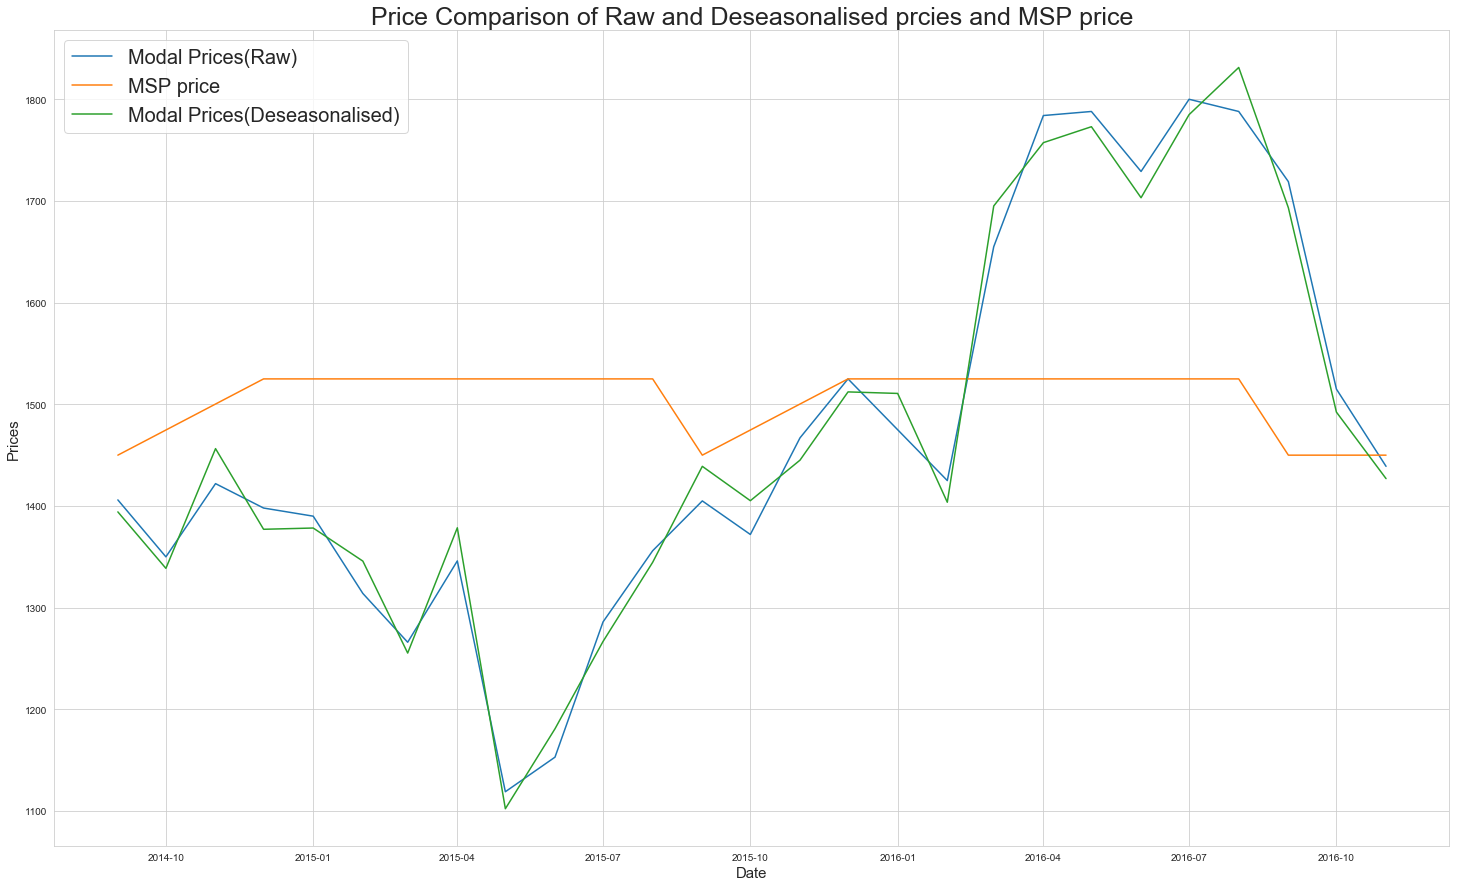

In [864]:
sns.lineplot(x=df5_deses_m.index,y=df5_deses_m['modal_price'],data=merged_df_BAJRI_test , label='Modal Prices(Raw)' )
sns.lineplot(x=df5_deses_m.index,y=merged_df_BAJRI_test['ms_price'],data=merged_df_BAJRI_test, label='MSP price')
sns.lineplot(x=df5_deses_m.index,y=merged_df_BAJRI_test['deseasonalised_prices'],data=merged_df_BAJRI_test, label='Modal Prices(Deseasonalised)')
plt.legend(loc='best',fontsize=20)
plt.title('Price Comparison of Raw and Deseasonalised prcies and MSP price' , fontsize=25)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Prices',fontsize=15)
rcParams['figure.figsize'] = 25, 15
#plt.figure(figsize(30,15))
plt.savefig('Comp Raw Des and MSP.jpg')

## MSP Comparison

In [ ]:
#This function takes the merged data frame as the input
#and the name of APMC and Commodity Cluster to get the datset with
#Modal Prices Raw and Deseasonalised , MSP Prices
#the dataframe thus obtained can be plotted to get the required curves


In [1012]:
def compareMSP(merged_df,comm,APMC,period):
    merge_df_sample=merged_df
    merged_df_sample = merged_df.loc[ (merged_df['Commodity']==comm) & (merged_df['APMC']==APMC)]
    ms_price=np.array(merged_df_sample['msprice'],dtype=float)
    merged_df_sample = merged_df_sample[['date', 'modal_price','msprice']]
    merged_df_sample['ms_price']=ms_price
    merged_df_sample = merged_df_sample[['date', 'modal_price','ms_price']]
    merged_df_sample.to_csv('merged_SAMPLE1.csv')
    #df5.dtypes # our datatypes for date column is in objects, we shall convert it to datetime 
    dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')

    merged_df_sample = pd.read_csv('merged_SAMPLE1.csv', parse_dates=['date'], index_col='date',date_parser=dateparse) # indexed the date column
    merged_df_sample = merged_df_sample[['modal_price','ms_price']]
    dfdes_temp=deseasonalise_data_mod(merged_df,period,comm,APMC)
    dfdes_temp['ms_price']=compare_df['ms_price']
    
    #merged_df_sample_des=merged_df_sample[['modal_price']]
    #merged_df_BAJRI_test = merged_df_BAJRI_test.fillna()
    #merged_df_BAJRI_test
    #merge_df_sample_des=deseasonalise_data_mod(merged_df,3,comm,APMC)
    #merge_df_sample_des['ms_price']= ms_price=np.array(merged_df_sample['msprice'],dtype=float)
    
    return dfdes_temp

## Flagging the Fluctuation Data

**Fluctutation is the diffrence between the minimum and maximum prices**

In [809]:
monthly_df_out['fluctuation'] = monthly_df_out['max_price'] - monthly_df_out['min_price']

In [810]:
monthly_df_out.head()

APMC Commodity  Year  Month arrivals_in_qtl  min_price  max_price  \
0 0   AHMEDNAGAR     BAJRI  2015  APRIL              79       1406       1538   
  1   AHMEDNAGAR     BAJRI  2016  APRIL             106       1788       1925   
  51       AKOLE     BAJRI  2015  APRIL              52       1357       1800   
  52       AKOLE     BAJRI  2016  APRIL              75       1460       1960   
  64     JAMKHED     BAJRI  2015  APRIL             164       1304       1446   

      modal_price     date district_name   state_name  fluctuation  
0 0          1463  2015-04    AHMADNAGAR  MAHARASHTRA          132  
  1          1875  2016-04    AHMADNAGAR  MAHARASHTRA          137  
  51         1525  2015-04    AHMADNAGAR  MAHARASHTRA          443  
  52         1685  2016-04    AHMADNAGAR  MAHARASHTRA          500  
  64         1375  2015-04    AHMADNAGAR  MAHARASHTRA          142

In [811]:
monthly_df_fluc=monthly_df_out.sort_values(['fluctuation','Year'], ascending=[False,False])

In [812]:
monthly_df_fluc.head(11)

APMC       Commodity  Year      Month arrivals_in_qtl  \
8  59715    UMARKHED  PIGEON PEA TUR  2016  SEPTEMBER             120   
11 14805     SHEGAON         SESAMUM  2015    OCTOBER               7   
   54146      BARSHI         SESAMUM  2014    OCTOBER               2   
8  11170      GEVRAI  PIGEON PEA TUR  2015      MARCH             423   
   24431     NILANGA  PIGEON PEA TUR  2015     AUGUST             158   
   14057      MEHKAR  PIGEON PEA TUR  2016      MARCH            1950   
   13639      MEHKAR  PIGEON PEA TUR  2015       JULY             100   
   37244      LOHARA  PIGEON PEA TUR  2015   DECEMBER             229   
   6796     DARYAPUR  PIGEON PEA TUR  2015       JUNE            6131   
9  62338      MUMBAI    RICEPADDYHUS  2016   NOVEMBER          606337   
8  15036  SANGRAMPUR  PIGEON PEA TUR  2015  SEPTEMBER             154   

          min_price  max_price  modal_price     date district_name  \
8  59715       5800      61200         6000  2016-09      YEWATMAL   
11 14805       6507      16793         6507  2015-10      BULDHANA   
   54146       1075      10500        10500  2014-10       SOLAPUR   
8  11170       4636      13085         5536  2015-03          BEED   
   24431       8262      15466         8861  2015-08         LATUR   
   14057       7062      13454         8134  2016-03      BULDHANA   
   13639       4150      10101         9250  2015-07      BULDHANA   
   37244       9022      14741         9568  2015-12     OSMANABAD   
   6796        4965      10561         7191  2015-06    AMARAVATHI   
9  62338       4562       9381         6023  2016-11        MUMBAI   
8  15036       4200       8900         8020  2015-09      BULDHANA   

           state_name  fluctuation  
8  59715  MAHARASHTRA        55400  
11 14805  MAHARASHTRA        10286  
   54146  MAHARASHTRA         9425  
8  11170  MAHARASHTRA         8449  
   24431  MAHARASHTRA         7204  
   14057  MAHARASHTRA         6392  
   13639  MAHARASHTRA         5951  
   37244  MAHARASHTRA         5719  
   6796   MAHARASHTRA         5596  
9  62338  MAHARASHTRA         4819  
8  15036  MAHARASHTRA         4700

In [ ]:
## we can clearly see the Maximum Fluctuation of each Commodity , APMC , Months

In [813]:
monthly_df_fluc_final = pd.DataFrame(monthly_df_fluc)

In [865]:
#Saving the Flagged Fluctuation in a seperate File

In [866]:
monthly_df_fluc_final.to_csv('Flagged Fluctuations.csv')

# EXAMPLES

**Running the Above Seasonality Removal on few Examples**

*The function **deseasonalise_data_mod()** takes 4 arguments the dataset , time period , Commodity and APMC Cluster we want*

the function uses the checkModel( ) function to Check which Model as in Additive or Multiplicative to be Used

The dataframe returned by this function is the the dataframe with the Deseasonalised prices which is our matter of interest

In [1031]:
des_data = deseasonalise_data_mod(df_final_out,3,"BAJRI","CHOPDA")


Multiplicative Model
Deseasonalising the Data using Multiplicative Model


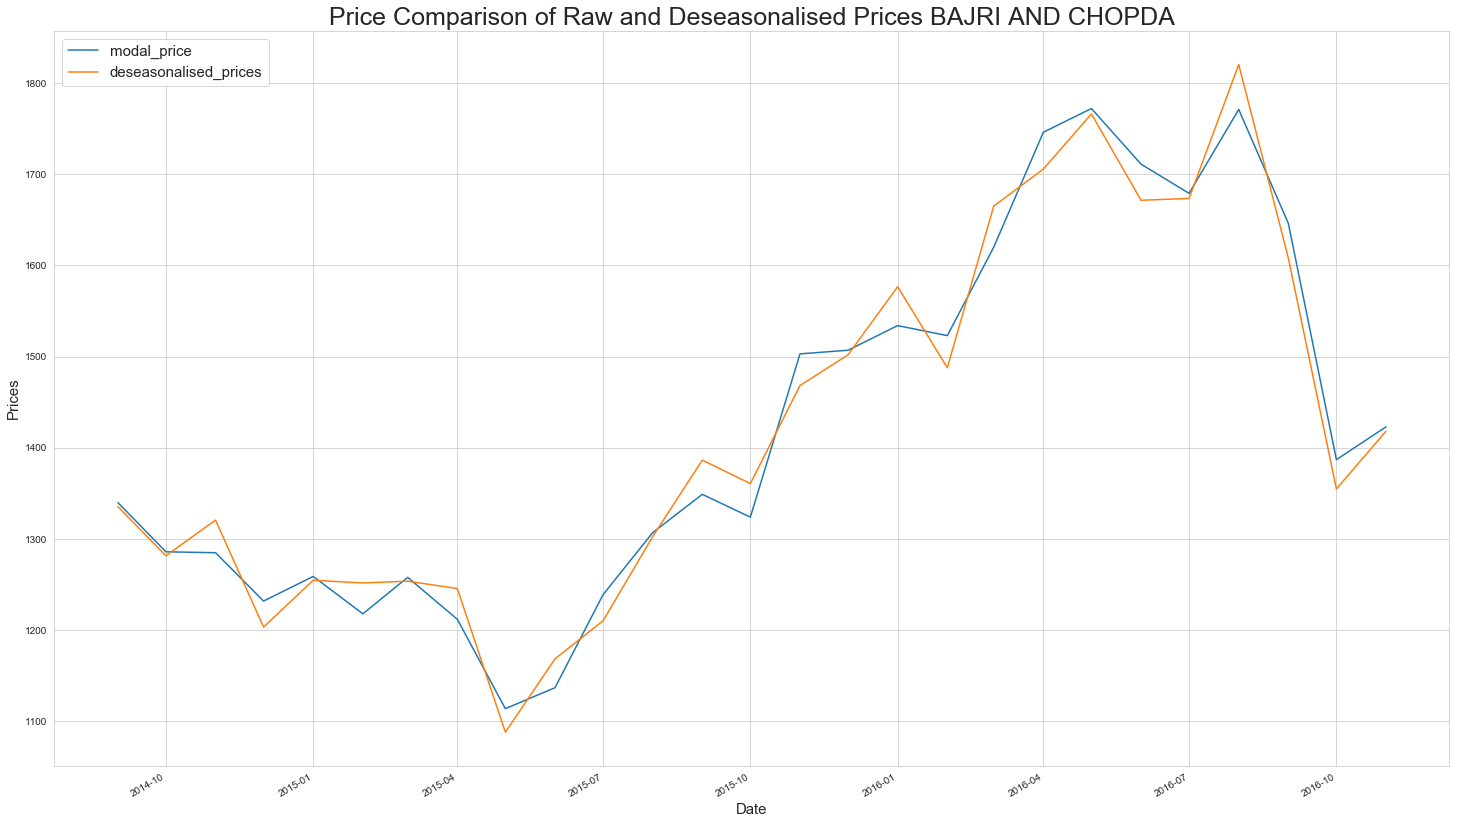

In [1034]:
des_data.plot()
plt.title('Price Comparison of Raw and Deseasonalised Prices BAJRI AND CHOPDA' , fontsize=25)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Prices',fontsize=15)
plt.legend(loc='best',fontsize=15)
rcParams['figure.figsize'] = 25, 15
#plt.figure(figsize(30,15))
plt.savefig('Price Comparison Raw and Deseasonalised1.jpg')

Multiplicative Model
Deseasonalising the Data using Multiplicative Model


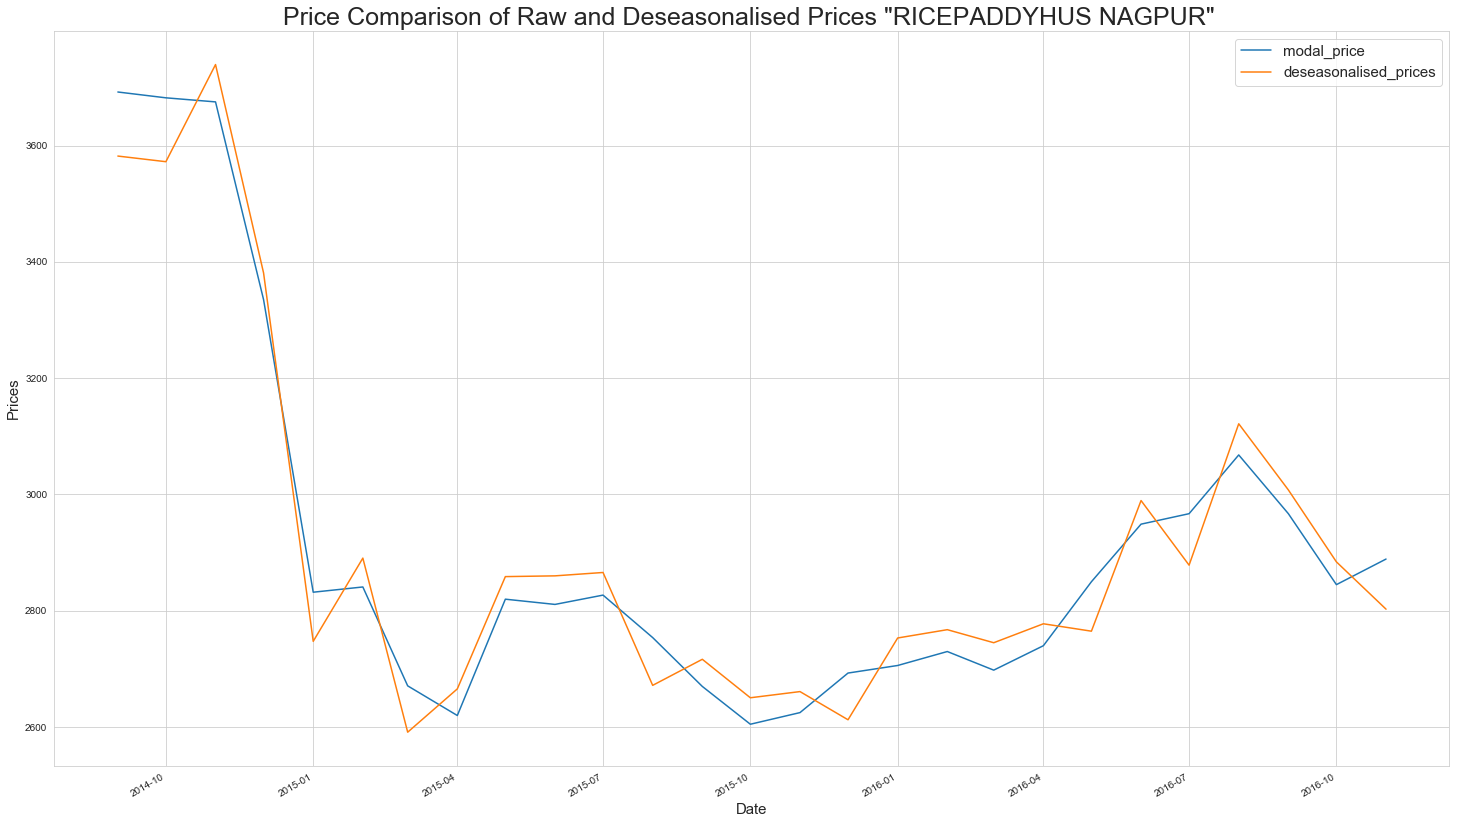

In [1035]:
des_data2 = deseasonalise_data_mod(df_final_out,3,"RICEPADDYHUS","NAGPUR")
des_data2.plot()
plt.title('Price Comparison of Raw and Deseasonalised Prices "RICEPADDYHUS NAGPUR" ' , fontsize=25)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Prices',fontsize=15)
plt.legend(loc='best',fontsize=15)
rcParams['figure.figsize'] = 25, 15
#plt.figure(figsize(30,15))
plt.savefig('Price Comparison Raw and Deseasonalised2.jpg')

## MSP Comparison Examples

In the Examples below we are using the compareMSP( ) Function for Comparison of Prices
the fucntion takes the four arguments the dataframe for comparison the APMC and Commodity names
and the period for calculating deseasonalising our Data

In [1013]:
temp_data = compareMSP(merged_df,"BAJRI","CHOPDA",3)

Multiplicative Model
Deseasonalising the Data using Multiplicative Model


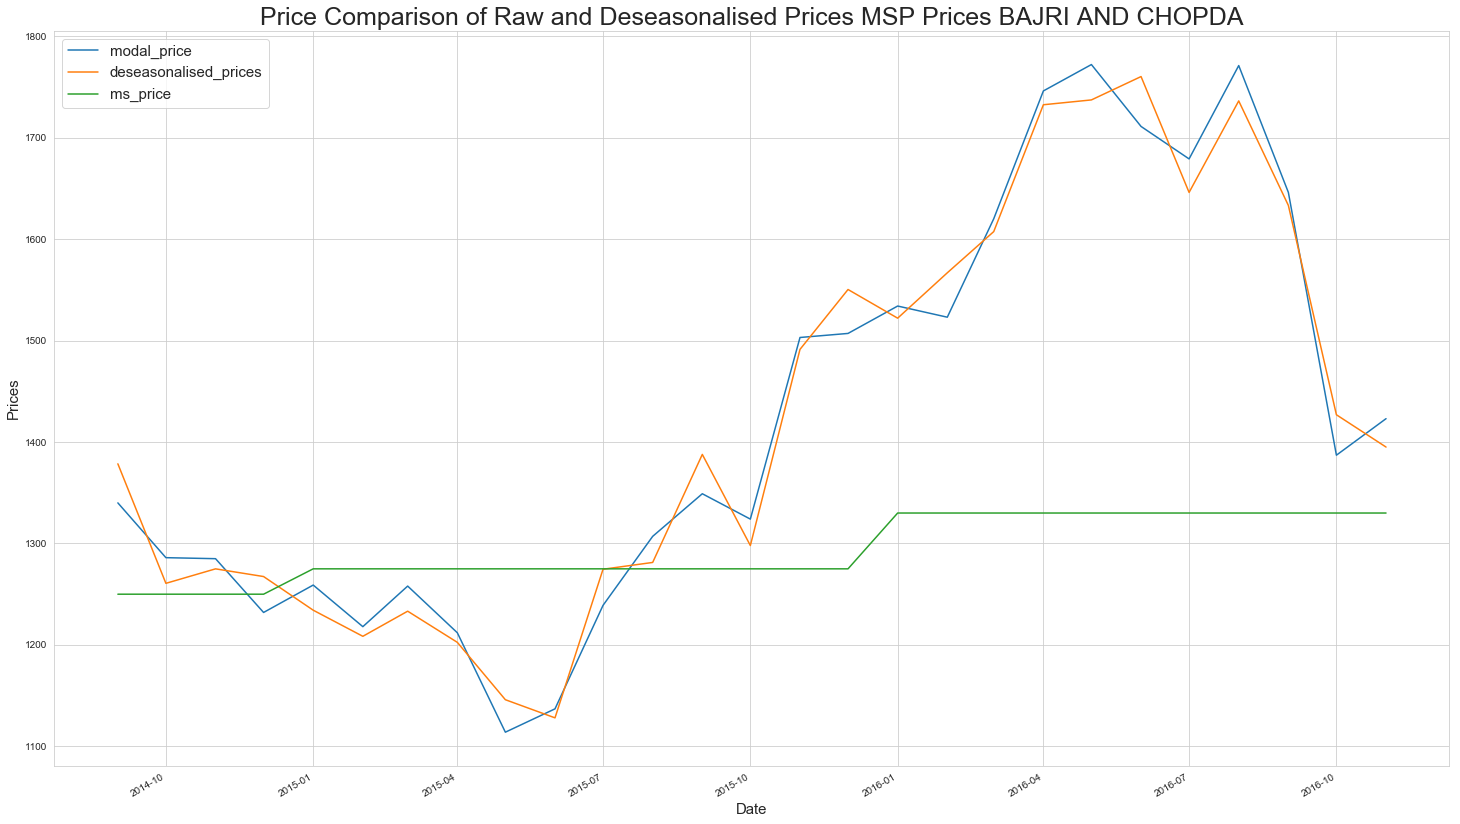

In [1020]:
temp_data.plot()
plt.title('Price Comparison of Raw and Deseasonalised Prices MSP Prices BAJRI AND CHOPDA' , fontsize=25)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Prices',fontsize=15)
plt.legend(loc='best',fontsize=15)
rcParams['figure.figsize'] = 25, 15
#plt.figure(figsize(30,15))
plt.savefig('Price Comparison Raw and DeseasonalisedSample1.jpg')

In [1015]:
temp_data_2 = compareMSP(merged_df,"SORGUMJAWAR","GANGAPUR",3)

Multiplicative Model
Deseasonalising the Data using Multiplicative Model


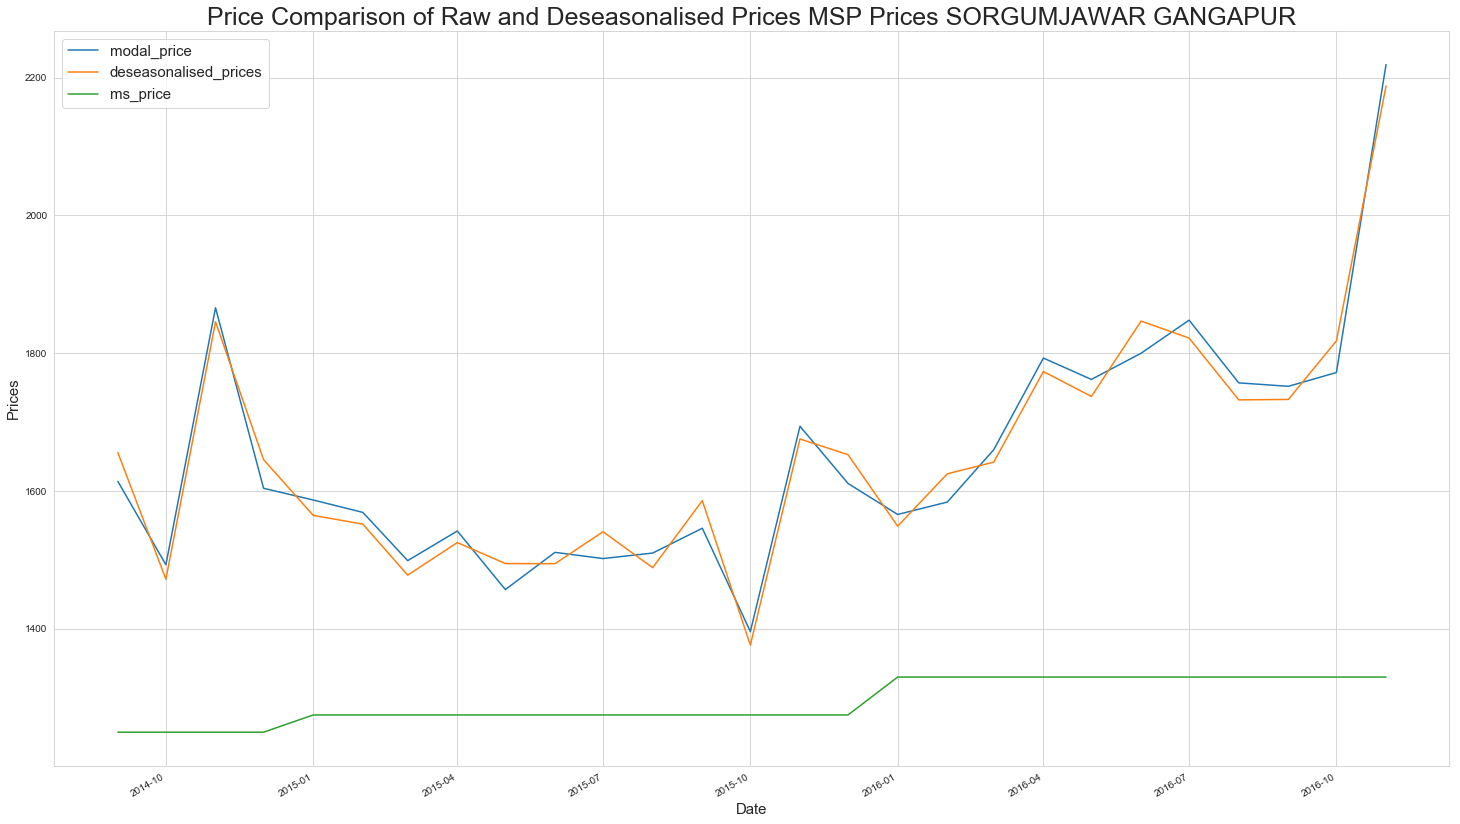

In [1036]:
temp_data_2.plot()
plt.title('Price Comparison of Raw and Deseasonalised Prices MSP Prices SORGUMJAWAR GANGAPUR' , fontsize=25)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Prices',fontsize=15)
plt.legend(loc='best',fontsize=15)
rcParams['figure.figsize'] = 25, 15
#plt.figure(figsize(30,15))
plt.savefig('Price Comparison Raw and DeseasonalisedSample2.jpg')

In [1037]:
temp_data3=compareMSP(merged_df,"BAJRI","JALGAON",3)

Multiplicative Model
Deseasonalising the Data using Multiplicative Model


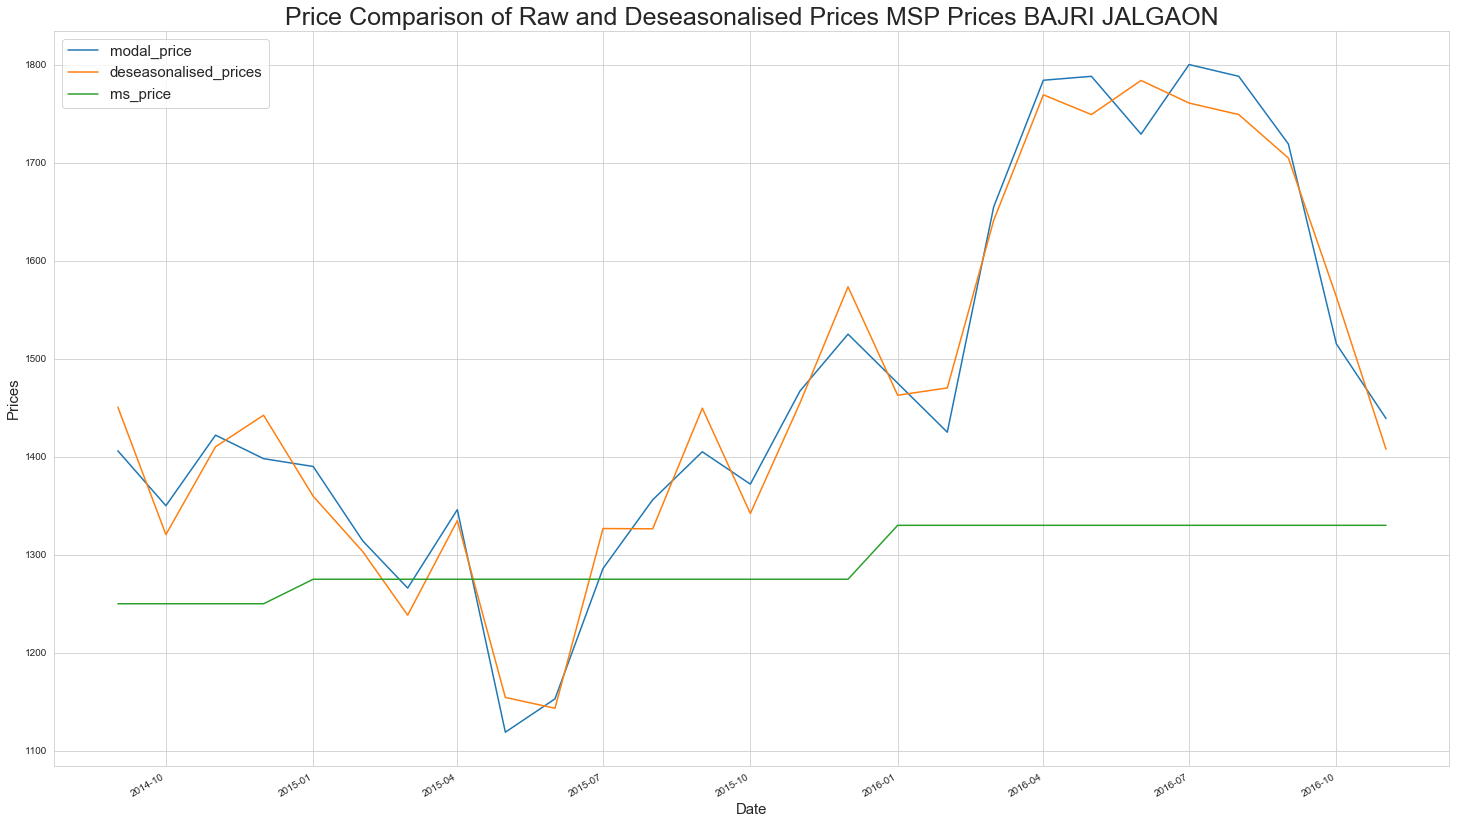

In [1038]:
temp_data3.plot()
plt.title('Price Comparison of Raw and Deseasonalised Prices MSP Prices BAJRI JALGAON' , fontsize=25)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Prices',fontsize=15)
plt.legend(loc='best',fontsize=15)
rcParams['figure.figsize'] = 25, 15
#plt.figure(figsize(30,15))
plt.savefig('Price Comparison Raw and DeseasonalisedSample3.jpg')

Multiplicative Model
Deseasonalising the Data using Multiplicative Model


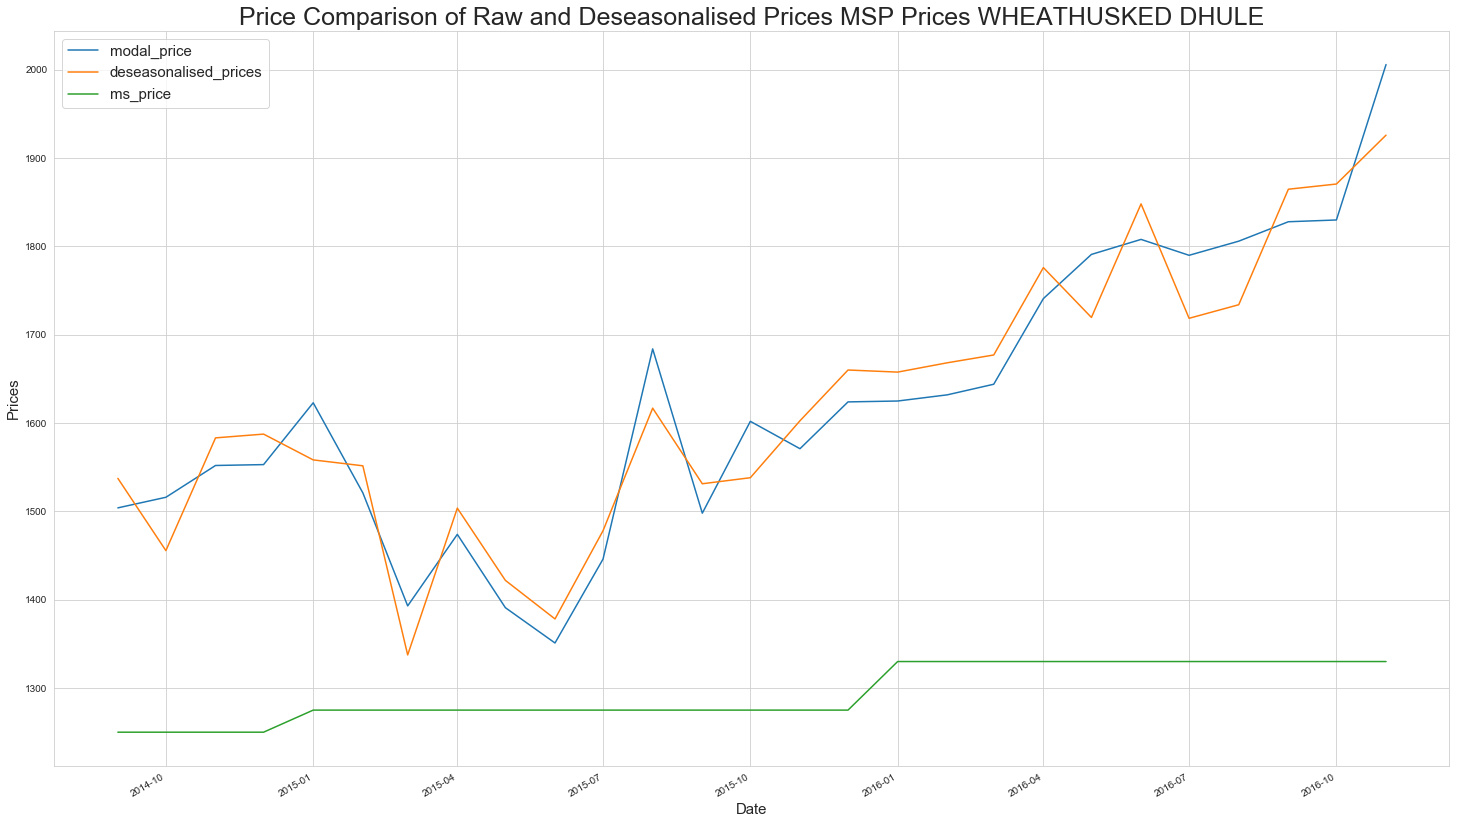

In [1039]:
temp_data4=compareMSP(merged_df,"WHEATHUSKED","DHULE",3)
temp_data4.plot()
plt.title('Price Comparison of Raw and Deseasonalised Prices MSP Prices WHEATHUSKED DHULE' , fontsize=25)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Prices',fontsize=15)
plt.legend(loc='best',fontsize=15)
rcParams['figure.figsize'] = 25, 15
#plt.figure(figsize(30,15))
plt.savefig('Price Comparison Raw and DeseasonalisedSample4.jpg')

## ANALYST NOTE


 * We have used IQR method for outlier removal for simplfying the process and this process being the most intuitive one
 
 * For removing the Seasonality from data and deseasonalising the dataset we need to simple use the functions    deserealise_data_mod() pass the relevant cluster of APMC and Commodity

*   Similarly for price comparison the compareMSP( ) needs to be used
 

*Thus both the above mthod can be used to simply run accross different clusters 
 the examples picked are those APMC and Commodity CLuster whih have enough data for which time series plot can be obtained and further process can take place*

# END NOTE

**A very interesting and challenging task with a lot of learning involved**

**I was completely new to concept of Time series , thus learing about Time Series then implementing the 
project within a period of 4 days a very challenging and thrilling experience**

**The most interesting part was the outlier removal task 
and then Seasonality removal and deseasonalising the data , where implmenting the seasonal_decompose on my own 
thus having a pretty good idea of how the seasonal decompose function actually works**



